## Predicting the Remaining Useful Life of NASA Turbofan Engines 
#### DSC 288R, Project Group #: 8, 
#### Author(s): Joyce Shiah 
##### Emails: jshiah@ucsd.edu

**About the project:** Predicting the Remaining Useful Life (RUL) of turbofan engines is critical for ensuring aviation safety, reliability, and efficiency. This project introduces an adaptive sliding window approach that dynamically adjusts its size to capture real-time degradation trends under varying operating conditions. Unlike traditional fixed-window methods, this approach adapts to fluctuating degradation rates, improving prediction accuracy, human safety, and reducing unnecessary maintenance. By extending maintenance intervals for engines experiencing slower degradation and accelerating intervention for rapid deterioration, the method optimizes resource allocation and enhances equipment longevity. A refined sensor selection strategy – based on feature importance analysis – demonstrated improved performance compared to previous studies on the NASA C-MAPSS dataset. This approach contributes to improved safety, reduced maintenance costs, and increased environmental sustainability by minimizing premature component replacements.

#### Directions:

##### Materials necessary for installation and set-up of Project reproduction:
1. `8-SW.zip` is the zip file for all source code and contains this README.txtm detailing instructions on how to compile and run the code. Download the .zip file and locate these key files: `train_FD001.txt`, `README.txt`, `G8_Milestone4.ipynb`, and `G8_Milestone4_Final_Report.pdf`.
2. To ensure a smooth experience with reproducing this project and its results, please run this project on your localhost Jupyter Notebook. If VS Code is strongly preferred, ensure your Python environment is set up correctly before proceeding any further. 
3. Take note of the `train_FD001.txt` facts before proceeding: The FD001 dataset (inside the .zip) is a simulated turbofan engine that operates on sea-level conditions with a high-pressure compressor degradation fault mode. FD001 contains 100 engine trajectories — each representing the operational history of a single engine unit — and a total of 20,631 performance snapshots. To use the dataset, download the file into your local drive and replace the Path Name with your local Path Name in this line: `df1 = pd.read_csv('/Users/JoyceShiah/Desktop/CMAPSSData/train_FD001.txt', sep="\s+", header=None, names=column_names, index_col=False)`. This line appears in the SECOND code chunk of the `G8_Milestone4.ipynb` Jupyter notebook.
Reference to dataset:
Saxena, A., & Goebel, K. (2008). Turbofan engine degradation simulation data set. NASA Prognostics Data Repository. NASA Ames Research Center.
4. Compile and ensure the first two code chunks, which contain the necessary imports of Python libraries, naming of columns, and the loading of the simulation dataset into the Pandas dataframe, all run successfully with no errors.
5. Once the first two code chunks are verified to have run successufully, please proceed to select from the Jupyter tabs "Run > Run All Cells." Please wait as the Notebook compiles to completion. As there are many algorithms that take up lots of computational resources and time, the estimated wait time for the successfull, complete compilation of `G8_Milestone4.ipynb` is: 7-8 minutes. There should be any compilation errors in this notebook, and only deprecation warnings will show up which you may ignore.
6. Please take the time to explore the contents of this script! All major decisions -- from data preprocessing, feature scaling, feature importance analysis, to model implementation -- include justification and discussions on key findings in Markdown cells. My entire thought process is relayed in these Markdown cells, and information parallel to the writing in the final report, `G8_Milestone4_Final_Report.pdf`, can be seen.
7. The step-by-step instructions as to how my pipeline went from exploratory data analysis, data preprocessing, feature scaling, feature importance analysis, to model implementation is fully flushed out in Markdown cells.

**Note:** The code, `G8_Milestone4.ipynb`, is already compiled on GitHub and models are all pre-trained. When downloading the .zip into your local system to reproduce the results, please use the GitHub version to compare with your findings.
Thank you very much in advance for reviewing my project! I hope you are able to gain some insight from my findings on accurate RUL prediction strategies.

In [340]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

# unit + time + 3 operational settings + 21 sensors = 26 cols total
column_names = [
    "unit", "time", "op_setting_1", "op_setting_2", "op_setting_3"
] + [f"sensor_{i}" for i in range(1, 22)]  

In [341]:
# train_FD001 simulation's conditions: ONE (Sea Level) and Fault Modes: ONE (HPC Degradation) 
# read_csv() works with .txt files
df1 = pd.read_csv('/Users/JoyceShiah/Desktop/CMAPSSData/train_FD001.txt', sep="\s+", header=None, names=column_names, index_col=False)

NOTE TO SELF: need `index_col = False` in order to correctly format `unit` and `time` columns (parse as integers) 

In [342]:
print(df1.info())
print(df1.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20631 entries, 0 to 20630
Data columns (total 26 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   unit          20631 non-null  int64  
 1   time          20631 non-null  int64  
 2   op_setting_1  20631 non-null  float64
 3   op_setting_2  20631 non-null  float64
 4   op_setting_3  20631 non-null  float64
 5   sensor_1      20631 non-null  float64
 6   sensor_2      20631 non-null  float64
 7   sensor_3      20631 non-null  float64
 8   sensor_4      20631 non-null  float64
 9   sensor_5      20631 non-null  float64
 10  sensor_6      20631 non-null  float64
 11  sensor_7      20631 non-null  float64
 12  sensor_8      20631 non-null  float64
 13  sensor_9      20631 non-null  float64
 14  sensor_10     20631 non-null  float64
 15  sensor_11     20631 non-null  float64
 16  sensor_12     20631 non-null  float64
 17  sensor_13     20631 non-null  float64
 18  sensor_14     20631 non-nu

## Data Cleaning and Pre-processing Stage

### Step 1: Identify & remove sensor columns w/ significant missing values, nulls, outliers
- drop if: columns contain only constant values
- before dropping them, verify if either provide meaningful variance

In [343]:
print(df1.nunique())

unit             100
time             362
op_setting_1     158
op_setting_2      13
op_setting_3       1
sensor_1           1
sensor_2         310
sensor_3        3012
sensor_4        4051
sensor_5           1
sensor_6           2
sensor_7         513
sensor_8          53
sensor_9        6403
sensor_10          1
sensor_11        159
sensor_12        427
sensor_13         56
sensor_14       6078
sensor_15       1918
sensor_16          1
sensor_17         13
sensor_18          1
sensor_19          1
sensor_20        120
sensor_21       4745
dtype: int64


#### Check for Missing Values

In [344]:
print(df1.isnull().sum())

unit            0
time            0
op_setting_1    0
op_setting_2    0
op_setting_3    0
sensor_1        0
sensor_2        0
sensor_3        0
sensor_4        0
sensor_5        0
sensor_6        0
sensor_7        0
sensor_8        0
sensor_9        0
sensor_10       0
sensor_11       0
sensor_12       0
sensor_13       0
sensor_14       0
sensor_15       0
sensor_16       0
sensor_17       0
sensor_18       0
sensor_19       0
sensor_20       0
sensor_21       0
dtype: int64


### Step 2: Sort Data by `unit` and `time` 
Since each unit runs for a certain time until engine failure, organize data by unit and progression of time.

In [345]:
df1 = df1.sort_values(by=["unit", "time"])
df1.head()

,unit,time,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


### Step 3: Calculate assigned Remaining Useful Life (RUL = number of time steps left before engine failure) value
- calculated RUL value --> TARGET VARIABLE for model (y variable)
- `RUL = Final Cycle − Current Cycle`
- formula for target RUL calculation: `.transform(lambda x: x.max() - x)`
    - group the data by each **engine** unit.
    - each engine has **multiple time steps**, starting from time = 1 and increasing until failure
    - for each engine, this finds the **maximum time value** (max = last recorded cycle before failure)
- `x.max() - x`
    - finds how many time steps are left before failure
    - e.g. RUL = 150 − 125 = 25
        - if an engine runs for 150 cycles and the current row has time = 125
- `.transform()` ensures calculation is applied within **each engine unit**, maintaining the original DataFrame structure

**Why this step of assigning RUL values (serves as the target variable for training your XGBoost model) is essential for building the adaptive sliding window approach:**

- goal is to predict RUL at each time step, so without calculating RUL first, you wouldn't have a supervised learning target for XGBoost
- adaptive sliding window model **learns from past sensor readings to predict future RUL**, so you need a **well-defined RUL label** for training
- adaptive sliding window approach dynamically adjusts the window size based on engine degradation rates. This means:
    - if an engine is **degrading slowly**, a longer history (larger window) is useful
    - If an engine is **degrading rapidly**, a shorter history (smaller window) is needed to focus on recent changes
- analyzing sensor behavior is critical for success in engine sustainability: without RUL, you wouldn't know how close an engine is to failure, making it impossible to adjust window size adaptively


**Difference between Fixed vs. Adaptive Sliding Window Approach:**

- Since this is comparing fixed vs. adaptive sliding windows, both need a consistent target variable --> RUL
- **Fixed Window:** uses a constant-length past sequence for prediction
    - fixed number of past time steps (e.g., the last 30 or 50 readings)
- **Adaptive Window:** uses RUL trends to adjust window size dynamically, so if RUL weren’t calculated first, it would be unclear when to adjust the window size, making adaptive modeling ineffective

In [346]:
df1["RUL"] = df1.groupby("unit")["time"].transform(lambda x: x.max() - x)

In [347]:
df1.head()

,unit,time,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


### Step 4: Visualization of the Calculated RUL distribution 
- visualize calculated RUL for each engine unit in FD001 Train dataset

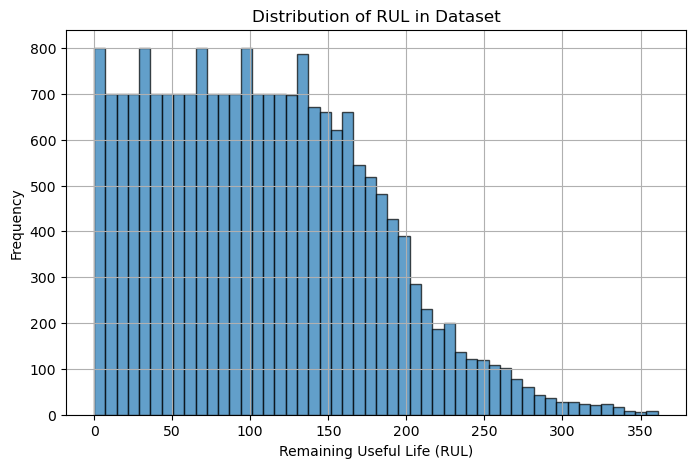

In [348]:
# max cycle per unit (engine)
max_cycle_per_unit = df1.groupby("unit")["time"].max()

# merge df to compute RUL
df1["RUL"] = df1["unit"].map(max_cycle_per_unit) - df1["time"]

plt.figure(figsize=(8, 5))
plt.hist(df1["RUL"], bins=50, edgecolor='black', alpha=0.7)
plt.xlabel("Remaining Useful Life (RUL)")
plt.ylabel("Frequency")
plt.title("Distribution of RUL in Dataset")
plt.grid(True)
plt.show()

### Discussion of graph:
- right-skewed distribution
- however, from 0 to around 128 RUL, there is a sudden spike every 20-30 RUL increments that go up to frequency of 800

#### Step 4.1: Going further into analysis of graph
Check `Frequency` table for RUL, to see if the RUL increments are artificially grouped

In [349]:
df1["RUL"].value_counts().sort_index().head(50)  # check the first 50 RUL values

RUL
0     100
1     100
2     100
3     100
4     100
5     100
6     100
7     100
8     100
9     100
10    100
11    100
12    100
13    100
14    100
15    100
16    100
17    100
18    100
19    100
20    100
21    100
22    100
23    100
24    100
25    100
26    100
27    100
28    100
29    100
30    100
31    100
32    100
33    100
34    100
35    100
36    100
37    100
38    100
39    100
40    100
41    100
42    100
43    100
44    100
45    100
46    100
47    100
48    100
49    100
Name: count, dtype: int64

Compare with `Engine` IDs

In [350]:
df1.groupby("RUL")["unit"].nunique().head(50)  # how many unique engines share the same RUL

RUL
0     100
1     100
2     100
3     100
4     100
5     100
6     100
7     100
8     100
9     100
10    100
11    100
12    100
13    100
14    100
15    100
16    100
17    100
18    100
19    100
20    100
21    100
22    100
23    100
24    100
25    100
26    100
27    100
28    100
29    100
30    100
31    100
32    100
33    100
34    100
35    100
36    100
37    100
38    100
39    100
40    100
41    100
42    100
43    100
44    100
45    100
46    100
47    100
48    100
49    100
Name: unit, dtype: int64

#### Step 4.2: Overlay a Kernel Density Estimate (KDE)

#### Discussion of analysis 
- for every Remaining Useful Life (RUL) value from 0 to 49, there are exactly 100 rows in the dataset where that RUL value appears
- since each row corresponds to an engine at a specific time step, this suggests that at every RUL step from 0 to 49, 100 different engines are recorded at that exact RUL value
- NASA C-MAPSS dataset follows a structured simulation, ensuring that each engine degrades in a uniform way
- all 100 engines reach RUL = 0 at some point, and they pass through the same RUL values at the same frequency during degradation

#### More about KDE Visualization
- visualize the distribution of data points in a smooth manner
    - KDE takes a set of data points and smooths them into a continuous curve
    - uses a kernel (a small window) around each data point to contribute to the overall density estimation

**So, KDE is a preferred visualization over histograms:** 
- KDE is especially useful for continuous data where you expect the distribution to change smoothly
- can capture the density's shape without being constrained by discrete bin edges
- from Seaborn documentation: KDE can produce a plot that is less cluttered and more interpretable, especially when drawing multiple distributions

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


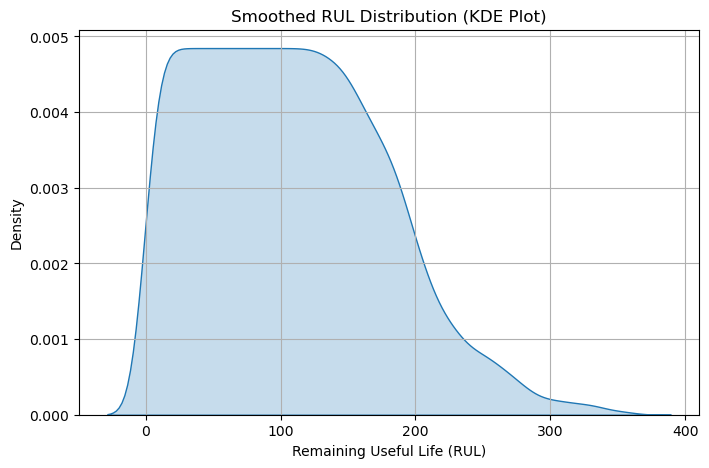

In [351]:
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.kdeplot(df1["RUL"], fill=True, bw_adjust=1)
plt.xlabel("Remaining Useful Life (RUL)")
plt.ylabel("Density")
plt.title("Smoothed RUL Distribution (KDE Plot)")
plt.grid(True)
plt.show()

### Discussion of KDE plot
- drop from 100 to 99 at RUL 128 means one engine unit had RUL = 128 cycles left
- not every engine unit reaches full capacity every cycle (natural wear and tear); some engines degrade faster than others, so they may fail before reaching RUL 128 

### Step 4.2: Analyze RUL distribution beyond 50 and check for similar patterns:

In [352]:
df1["RUL"].value_counts().sort_index()[100:150]  # See counts for RUL values between 100-150

RUL
100    100
101    100
102    100
103    100
104    100
105    100
106    100
107    100
108    100
109    100
110    100
111    100
112    100
113    100
114    100
115    100
116    100
117    100
118    100
119    100
120    100
121    100
122    100
123    100
124    100
125    100
126    100
127    100
128     99
129     99
130     99
131     99
132     99
133     99
134     99
135     98
136     98
137     96
138     96
139     96
140     96
141     96
142     96
143     96
144     96
145     96
146     96
147     94
148     94
149     94
Name: count, dtype: int64

In [353]:
df1.groupby("RUL")["unit"].nunique()[100:150]


RUL
100    100
101    100
102    100
103    100
104    100
105    100
106    100
107    100
108    100
109    100
110    100
111    100
112    100
113    100
114    100
115    100
116    100
117    100
118    100
119    100
120    100
121    100
122    100
123    100
124    100
125    100
126    100
127    100
128     99
129     99
130     99
131     99
132     99
133     99
134     99
135     98
136     98
137     96
138     96
139     96
140     96
141     96
142     96
143     96
144     96
145     96
146     96
147     94
148     94
149     94
Name: unit, dtype: int64

### Step 4.3: Calculate the correlation matrix for the features to identify relationships between sensor data, operational settings, and RUL. 

/opt/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


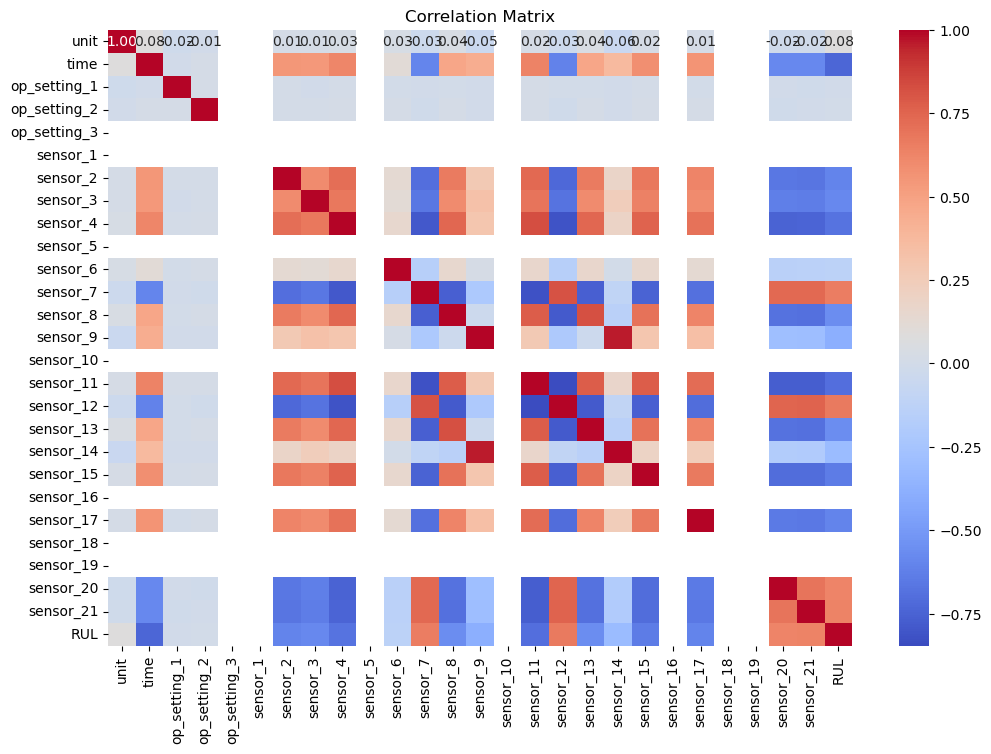

In [354]:
plt.figure(figsize=(12, 8))
correlation_matrix = df1.corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

Start with a Common Threshold: Begin with a threshold of 0.5, as it's a commonly used benchmark for indicating a moderate to strong correlation.

In [355]:
correlation_matrix = df1.corr()

# set a threshold for filtering (default)
threshold = 0.5

# find significant correlations
significant_correlations = correlation_matrix[(correlation_matrix >= threshold) | (correlation_matrix <= -threshold)]
print(significant_correlations.stack().reset_index().rename(columns={0: 'correlation'}))

    level_0    level_1  correlation
0      unit       unit     1.000000
1      time       time     1.000000
2      time   sensor_2     0.549898
3      time   sensor_3     0.543947
4      time   sensor_4     0.624577
..      ...        ...          ...
195     RUL  sensor_15    -0.642667
196     RUL  sensor_17    -0.606154
197     RUL  sensor_20     0.629428
198     RUL  sensor_21     0.635662
199     RUL        RUL     1.000000

[200 rows x 3 columns]


#### Display 10 highest and bottom 10 correlations

In [356]:
correlation_matrix = df1.corr()

threshold = 0.5

significant_correlations = correlation_matrix[(correlation_matrix >= threshold) | (correlation_matrix <= -threshold)]

# retrieve significant correlations, reset index
significant_correlations = significant_correlations.stack().reset_index().rename(columns={0: 'correlation'})

# filter out self-correlations (own variable)
significant_correlations = significant_correlations[significant_correlations['level_0'] != significant_correlations['level_1']]

# find top 10 highest correlations
top_10_correlations = significant_correlations.nlargest(10, 'correlation')

# find bottom 10 lowest correlations (most negative)
bottom_10_correlations = significant_correlations.nsmallest(10, 'correlation')

print("Top 10 Highest Correlations:")
print(top_10_correlations)

print("\nBottom 10 Lowest Correlations:")
print(bottom_10_correlations)

Top 10 Highest Correlations:
       level_0    level_1  correlation
86    sensor_9  sensor_14     0.963157
128  sensor_14   sensor_9     0.963157
49    sensor_4  sensor_11     0.830136
90   sensor_11   sensor_4     0.830136
79    sensor_8  sensor_13     0.826084
119  sensor_13   sensor_8     0.826084
65    sensor_7  sensor_12     0.812713
105  sensor_12   sensor_7     0.812713
77    sensor_8  sensor_11     0.782213
92   sensor_11   sensor_8     0.782213

Bottom 10 Lowest Correlations:
       level_0    level_1  correlation
94   sensor_11  sensor_12    -0.846884
107  sensor_12  sensor_11    -0.846884
64    sensor_7  sensor_11    -0.822805
91   sensor_11   sensor_7    -0.822805
50    sensor_4  sensor_12    -0.815591
104  sensor_12   sensor_4    -0.815591
47    sensor_4   sensor_7    -0.793130
61    sensor_7   sensor_4    -0.793130
109  sensor_12  sensor_13    -0.788441
121  sensor_13  sensor_12    -0.788441


### Discussion of Top 10, Bottom 10 Correlation Analysis
Top 10 Highest Correlations:
- pairs like `sensor_9` and `sensor_14` have a very high correlation of 0.963
    - shows that as one sensor's readings increase, the other sensor's readings tend to increase as well --> suggesting a strong linear relationship
Bottom 10 Lowest Correlations:
- pairs such as `sensor_11` and `sensor_12`, have a strong negative correlation of -0.847
    - as one sensor's readings increase, the other sensor's readings tend to decrease --> inverse relationship

In [357]:
# # Testing different thresholds
# thresholds = [0.3, 0.5, 0.7, 0.9]
# for threshold in thresholds:
#     significant_correlations = correlation_matrix[(correlation_matrix >= threshold) | (correlation_matrix <= -threshold)]
#     print(f"\nSignificant correlations at threshold {threshold}:")
#     print(significant_correlations.stack().reset_index().rename(columns={0: 'correlation'}))

### Step 4.4: Analyze Sensor Trends 
- stable line: relatively horizontal line = relatively stable over the observed time period
    - engine is operating under stable conditions or  internal calibration problems

- fluctuating line: varying readings (not horizontal) = sensors reacting to changing operational conditions
    - may be valuable for understanding engine performance and health

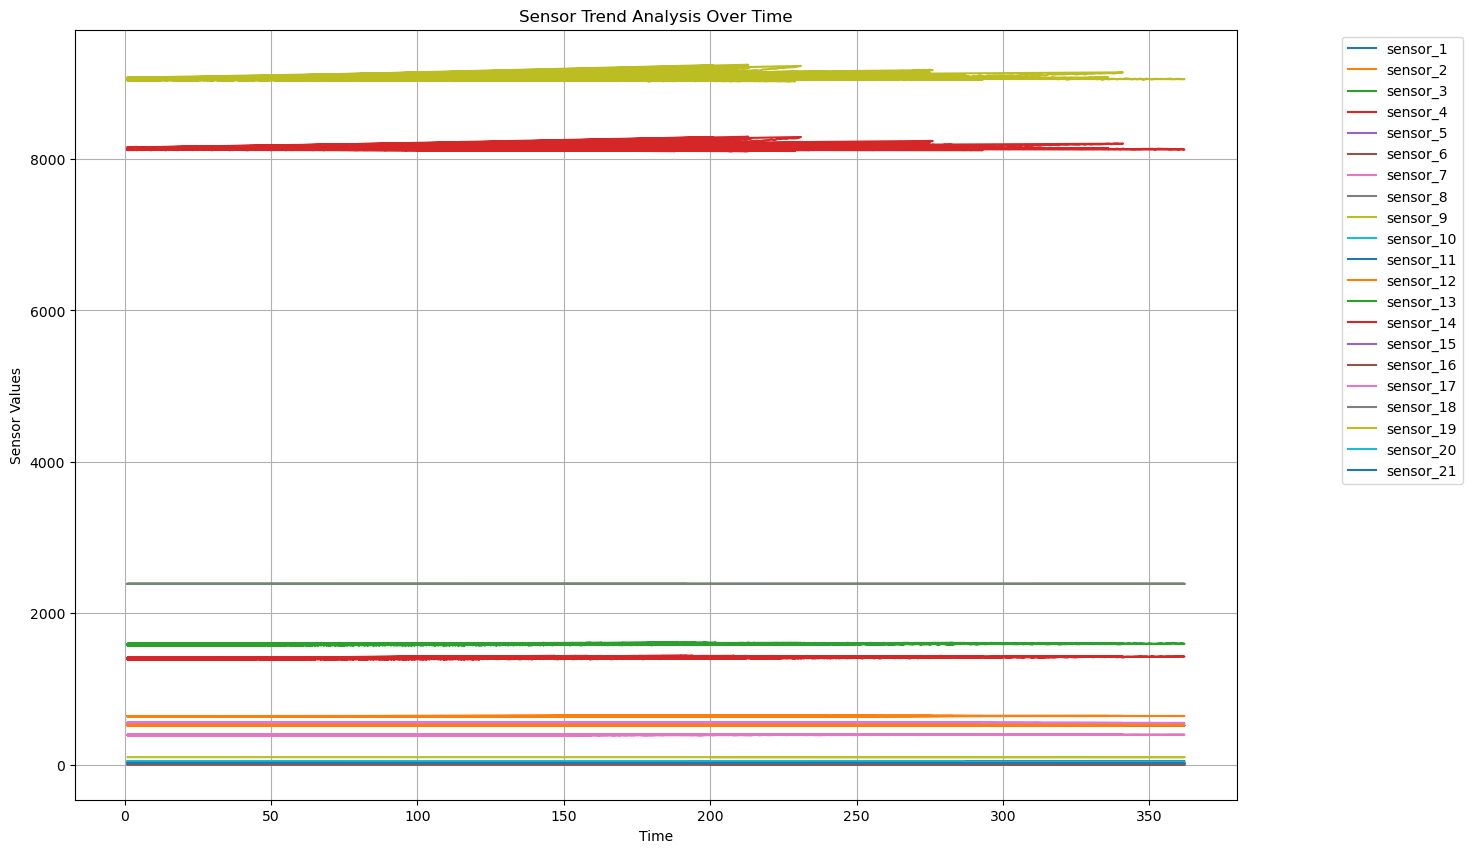

In [358]:
# analyze all sensors from 1 to 21)
key_sensors = [f'sensor_{i}' for i in range(1, 22)]

# plot each selected sensor on 1 graph
plt.figure(figsize=(15, 10))
for sensor in key_sensors:
    plt.plot(df1['time'], df1[sensor], label=sensor)
plt.title('Sensor Trend Analysis Over Time')
plt.xlabel('Time')
plt.ylabel('Sensor Values')
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
plt.grid()
plt.show()

### Sanity Check on # of columns

In [359]:
len(df1.columns)

27

# Addressing TA's feedback from Milestone 2:

"No discussion on feature extraction: The report states that raw sensor data is sufficient, but it does not explore whether transformations (e.g., moving averages, trend indicators) could improve model performance.

Handling of temporal dependencies: Since engine degradation follows a time series pattern, no mention is made of temporal features (e.g., cumulative degradation metrics, rolling window statistics)."

### Temporal features implememtation

#### Cumulative degradation metrics
Remaining cycles (RUL) decreases over time. A cumulative sum of certain sensor readings can help model degradation better.

In [360]:
df1['sensor_2_cumsum'] = df1.groupby("unit")['sensor_2'].cumsum()

#### Rolling Window Statistics
Compute moving averages or standard deviations of sensor values over a window (e.g., last 5 cycles) to capture short-term trends.

In [361]:
window_size = 5
sensor_columns = [f"sensor_{i}" for i in range(1, 22)]

for sensor in sensor_columns:
    df1[f"{sensor}_rolling_mean"] = df1.groupby("unit")[sensor].rolling(window=window_size).mean().reset_index(level=0, drop=True)
    df1[f"{sensor}_rolling_std"] = df1.groupby("unit")[sensor].rolling(window=window_size).std().reset_index(level=0, drop=True)

## Feature Importance Analysis Stage
#### Preparing for RUL Prediction (USING RAW FEATURES (from NASA CMAPSS `df1` dataset) ONLY)

In [362]:
# using df1 "RAW features only" Feature Importance model 

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# original sensor features
sensor_columns = [f"sensor_{i}" for i in range(1, 22)]
op_settings = ["op_setting_1", "op_setting_2", "op_setting_3"]
feature_columns = sensor_columns + op_settings

df1['RUL'] = df1.groupby('unit')['time'].transform(lambda x: x.max() - x)  # Example RUL calculation

# split into features and target
X = df1[feature_columns]
y = df1['RUL'] # calc RUL from EDA stage

# split data into training and validation sets
X_train_raw, X_val_raw, y_train_raw, y_val_raw = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# train XGBoost model
xgb_raw = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=100, random_state=42)
xgb_raw.fit(X_train_raw, y_train_raw)

# predict and evaluate
y_pred_raw = xgb_raw.predict(X_val_raw)
rmse_raw = mean_squared_error(y_val_raw, y_pred_raw, squared=False)

print(f"Baseline Model (Raw Features) RMSE: {rmse_raw:.4f}")

Baseline Model (Raw Features) RMSE: 43.4001


/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


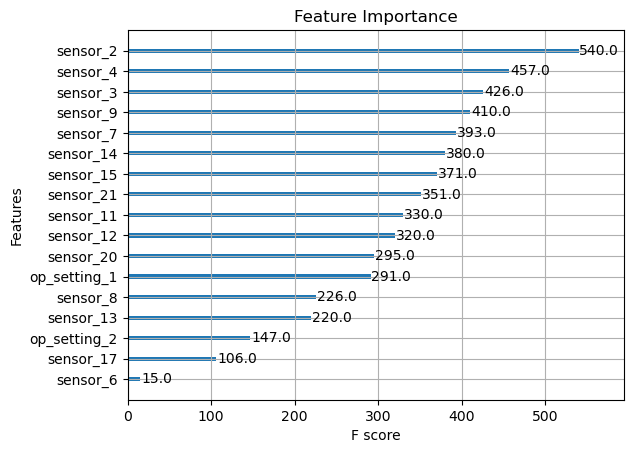

In [363]:
# visualize
xgb.plot_importance(xgb_raw)
plt.title('Feature Importance')
plt.show()

### Discussion of Feature Importance XGBoost model on RAW Features only 
Top Features Contributing to RUL Prediction
- Most Significant Sensors:
    - sensor_2: F score = 540.0
    - sensor_4: F score = 457.0
    - sensor_3: F score = 426.0
    - sensor_9: F score = 410.0
    - sensor_7: F score = 393.0
- Additional Noteworthy Sensors:
    - sensor_14: F score = 380.0
    - sensor_15: F score = 371.0
    - sensor_21: F score = 351.0
    - sensor_11: F score = 330.0
    - sensor_12: F score = 320.0
    - sensor_20: F score = 295.0
- Operational Settings:
    - op_setting_1: F score = 291.0
    - op_setting_2: F score = 220.0
    - op_setting_2: F score = 147.0
- Least Important Features:
    - sensor_17: F score = 106.0
    - sensor_6: F score = 15.0

### Compared to Wang, T., Yu, J., Siegel, D., & Lee, J. (2008):
- A similarity based prognostics approach for remaining useful life estimation of engineered systems' report
     - Common sensors: 2, 3, 4, 7, 11, 12, 15, 20, 21
     - **Next action:** Sensor 9 & 14 could capture short-term variations that improve RMSE but weren’t manually chosen by Wang et al.

## Selected Sensor subsets
- Model 1: Wang et al.’s sensors → (2, 3, 4, 7, 11, 12, 15, 20, 21)
- Model 2: XGBoost’s top-ranked sensors → (2, 3, 4, 7, 9, 11, 12, 14, 15, 20, 21)
- Model 3: All sensors → (1–21)

#### Step 1: Compute Feature Correlation
Check whether sensor 9 and sensor 14 are highly correlated with Wang et al.’s selected sensors.

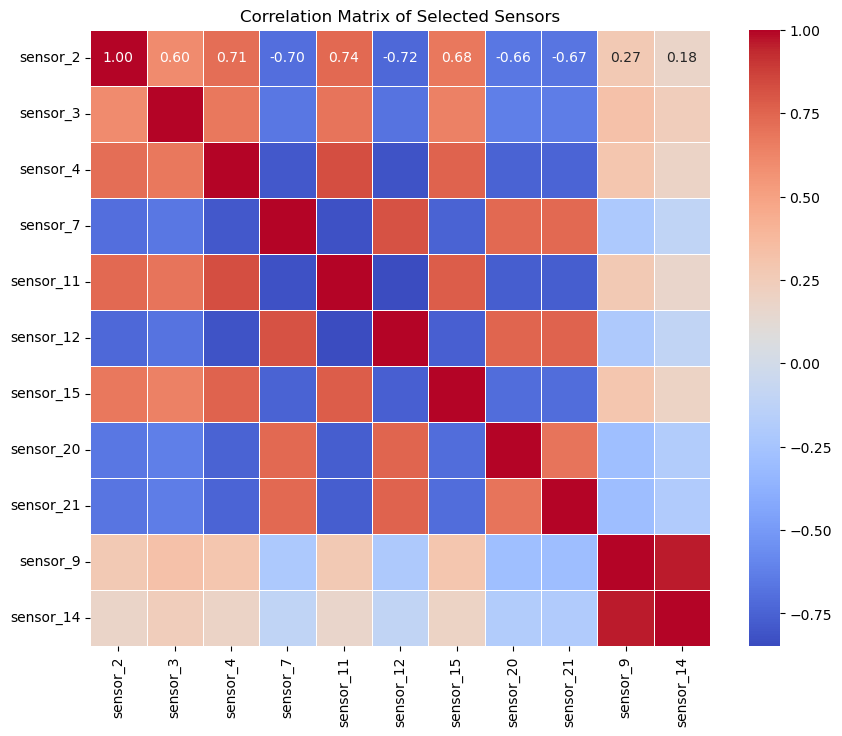

In [364]:
# sensors from Wang et al. (2008)
wang_sensors = ["sensor_2", "sensor_3", "sensor_4", "sensor_7", "sensor_11", "sensor_12", "sensor_15", "sensor_20", "sensor_21"]

# sensors XGBoost used that Wang et al. did not
extra_sensors = ["sensor_9", "sensor_14"]

##############################################
#### New Update on 3/13/25: Testing out adding ONLY sensor_9 or sensor_14 to see if RUL prediction RMSE can be lowered even more
#### Since sensor 9 and 14 have highest correlation to one another (coeff of 0.96), so could be redundant info from both sensors 
##############################################
sensor_9_addition = ["sensor_9"]   # test only sensor 9
sensor_14_addition = ["sensor_14"] # test only sensor 14


# subset of relevant sensors
selected_sensors = wang_sensors + extra_sensors

correlation_matrix = df1[selected_sensors].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Selected Sensors")
plt.show()

#### Discussion: Sensor 9 or sensor 14 have a very high correlation (0.963) with Wang et al.’s sensors. 

#### Step 2: Train Three Models & Compare RMSE
Train and evaluate three models using XGBoost

In [365]:
from sklearn.metrics import mean_squared_error
import numpy as np

# 3 feature sets of sensors
X_wang = df1[wang_sensors] # Wang et al.'s subset
X_xgb = df1[list(set(wang_sensors + extra_sensors))]  # XGBoost-selected
X_all = df1[[f"sensor_{i}" for i in range(1, 22)]]  # all 21 sensors

y_train = df1["RUL"]

model_wang = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=100, random_state=42)
model_xgb = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=100, random_state=42)
model_all = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=100, random_state=42)

model_wang.fit(X_wang, y_train)
model_xgb.fit(X_xgb, y_train)
model_all.fit(X_all, y_train)

y_pred_wang = model_wang.predict(X_wang)
y_pred_xgb = model_xgb.predict(X_xgb)
y_pred_all = model_all.predict(X_all)

rmse_wang = np.sqrt(mean_squared_error(y_train, y_pred_wang))
rmse_xgb = np.sqrt(mean_squared_error(y_train, y_pred_xgb))
rmse_all = np.sqrt(mean_squared_error(y_train, y_pred_all))

print(f"RMSE using Wang et al. Sensors: {rmse_wang:.4f}")
print(f"RMSE using XGBoost Selected Sensors: {rmse_xgb:.4f}")
print(f"RMSE using All Sensors: {rmse_all:.4f}")


RMSE using Wang et al. Sensors: 33.5504
RMSE using XGBoost Selected Sensors: 29.0049
RMSE using All Sensors: 28.7453


# Important Discussion: Regarding Occam's Razor
XGBoost’s selected sensors (RMSE = 29.00) outperform Wang et al.’s selection (RMSE = 33.55)
- This suggests that sensors 9 and 14 provide valuable predictive information that Wang et al. overlooked.
- Your feature importance analysis was effective in selecting relevant sensors.

Using all sensors (RMSE = 28.75) only marginally improves RMSE compared to XGBoost’s selection (RMSE = 29.00)
- This implies that many of the extra sensors don’t add much value.
- Keeping fewer, highly relevant sensors can simplify the model while maintaining strong performance
    - aligns with **Occam's razor** --> simplest strategy is best for explaining data more accurately
    - Using fewer but more informative sensors reduces model complexity → This makes training faster, reduces overfitting risk, and keeps predictions interpretable.
    - So, unless the slight RMSE reduction from using all sensors (28.75 vs. 29.00) is critical, Occam’s Razor suggests sticking with the most important sensors instead of using everything.

In [366]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

model = XGBRegressor(objective="reg:squarederror", n_estimators=100, random_state=42)

This specific code chunk below was apart of the EDA Milestone to test out each of the subset of sensors fared with the proposed XGBoost model approach from Milestone 1. 

In [367]:
### compare all 3 sensor feature sets

X_wang = df1[wang_sensors]
X_xgb = df1[list(set(wang_sensors + extra_sensors))]  # XGBoost selected sensors (Wang's + XGBoost-selected) 
X_all = df1[[f"sensor_{i}" for i in range(1, 22)]]  # all 21 sensors

y_train = df1["RUL"]

# initialize xgb models
model_wang = XGBRegressor(objective="reg:squarederror", n_estimators=100, random_state=42)
model_xgb = XGBRegressor(objective="reg:squarederror", n_estimators=100, random_state=42)
model_all = XGBRegressor(objective="reg:squarederror", n_estimators=100, random_state=42)

# train
model_wang.fit(X_wang, y_train)
model_xgb.fit(X_xgb, y_train)
model_all.fit(X_all, y_train)

# predictions
y_pred_wang = model_wang.predict(X_wang)
y_pred_xgb = model_xgb.predict(X_xgb)
y_pred_all = model_all.predict(X_all)

##############################################
## Error Reporting (RMSE and R^2)
##############################################

# calc RMSE
rmse_wang = np.sqrt(mean_squared_error(y_train, y_pred_wang))
rmse_xgb = np.sqrt(mean_squared_error(y_train, y_pred_xgb))
rmse_all = np.sqrt(mean_squared_error(y_train, y_pred_all))

print(f"RMSE using Wang et al. Sensors: {rmse_wang:.4f}")
print(f"RMSE using XGBoost Selected Sensors: {rmse_xgb:.4f}")
print(f"RMSE using All Sensors: {rmse_all:.4f}")

# calc R^2
r2_wang = r2_score(y_train, y_pred_wang)
r2_xgb = r2_score(y_train, y_pred_xgb)
r2_all = r2_score(y_train, y_pred_all)

print(f"R² using Wang et al. Sensors: {r2_wang:.4f}")
print(f"R² using XGBoost Selected Sensors: {r2_xgb:.4f}")
print(f"R² using All Sensors: {r2_all:.4f}")

##############################################
#### New Update on 3/13/25: Testing out adding ONLY sensor_9 or sensor_14 to see if RUL prediction RMSE can be lowered even more
#### Since sensor 9 and 14 have highest correlation to one another (coeff of 0.96), so could be redundant info from both sensors 
##############################################
X_s9 = df1[list(set(wang_sensors + sensor_9_addition))]  # XGBoost selected sensors (Wang's + sensor 9) 
X_s14 = X_xgb = df1[list(set(wang_sensors + sensor_14_addition))]  # XGBoost selected sensors (Wang's + sensor 14) 

model_s9 = XGBRegressor(objective="reg:squarederror", n_estimators=100, random_state=42)
model_s14 = XGBRegressor(objective="reg:squarederror", n_estimators=100, random_state=42)

model_s9.fit(X_s9, y_train)
model_s14.fit(X_s14, y_train)

y_pred_s9 = model_s9.predict(X_s9)
y_pred_s14 = model_s14.predict(X_s14)

##############################################
## Error Reporting (RMSE and R^2)
##############################################

rmse_s9 = np.sqrt(mean_squared_error(y_train, y_pred_s9))
rmse_s14 = np.sqrt(mean_squared_error(y_train, y_pred_s14))

print(f"RMSE using Wang et al. + Sensor 9: {rmse_s9:.4f}")
print(f"RMSE using Wang et al. + Sensor 14: {rmse_s14:.4f}")

r2_s9 = r2_score(y_train, y_pred_s9)
r2_s14 = r2_score(y_train, y_pred_s14)

print(f"R² using Wang et al. + Sensor 9: {r2_s9:.4f}")
print(f"R² using Wang et al. + Sensor 14: {r2_s14:.4f}")

RMSE using Wang et al. Sensors: 33.5504
RMSE using XGBoost Selected Sensors: 29.0049
RMSE using All Sensors: 28.7453
R² using Wang et al. Sensors: 0.7627
R² using XGBoost Selected Sensors: 0.8227
R² using All Sensors: 0.8258
RMSE using Wang et al. + Sensor 9: 29.7147
RMSE using Wang et al. + Sensor 14: 29.9585
R² using Wang et al. + Sensor 9: 0.8139
R² using Wang et al. + Sensor 14: 0.8108


## Feature Engineering
Scale using StandardScaler to significantly improve performance
- sensors have different ranges & units

In [368]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# scale features
X_wang_scaled = scaler.fit_transform(X_wang)
X_xgb_scaled = scaler.fit_transform(X_xgb)
X_all_scaled = scaler.fit_transform(X_all)

##############################################
#### New Update on 3/13/25: Testing out adding ONLY sensor_9 or sensor_14 to see if RUL prediction RMSE can be lowered even more
#### Scale both X_s9 and X_s14 to remain consistent 
##############################################
X_s9_scaled = scaler.fit_transform(X_s9)
X_s14_scaled = scaler.fit_transform(X_s14)

In [369]:
import xgboost as xgb
from xgboost import XGBRegressor
model_wang = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=500, random_state=42)

## Model Implementation stage
### `X_wang_scaled` applies sensors → (2, 3, 4, 7, 11, 12, 15, 20, 21)

In [370]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

#### Stacking (RMSE = 20.4869, R² = 0.9115)

In [371]:
# X_wang_scaled
estimators = [
    ('xgb', xgb.XGBRegressor(n_estimators=100, random_state=42)),
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42))
]
model_stack = StackingRegressor(estimators=estimators, final_estimator=LinearRegression())
model_stack.fit(X_wang_scaled, y_train)
y_pred_stack = model_stack.predict(X_wang_scaled)

rmse_stack = np.sqrt(mean_squared_error(y_train, y_pred_stack))
print(f"RMSE using Stacking with Wang et al.'s subset of sensors: {rmse_stack:.4f}")

r2_stack = r2_score(y_train, y_pred_stack)
print(f"R² using Stacking with Wang et al.'s subset of sensors: {r2_stack:.4f}")

RMSE using Stacking with Wang et al.'s subset of sensors: 20.4869
R² using Stacking with Wang et al.'s subset of sensors: 0.9115


#### Linear Regression (RMSE = 44.7125, R² = 0.5779)

In [372]:
from sklearn.linear_model import LinearRegression
y_train = df1["RUL"]

linear_model = LinearRegression()

linear_model.fit(X_xgb_scaled, y_train)

y_pred_lr = linear_model.predict(X_xgb_scaled)

rmse_lr = np.sqrt(mean_squared_error(y_train, y_pred_lr))
print(f"RMSE using Linear Regression: {rmse_lr:.4f}")

r2_lr = r2_score(y_train, y_pred_lr)
print(f"R² using Linear Regression: {r2_lr:.4f}")

RMSE using Linear Regression: 44.7522
R² using Linear Regression: 0.5779


#### [SCALED DATASET] Random Forest Regressor (RMSE = 17.3627, R² = 0.9365)

In [373]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

rf_model.fit(X_wang_scaled, y_train)

y_pred_rf = rf_model.predict(X_wang_scaled)

rmse_rf = np.sqrt(mean_squared_error(y_train, y_pred_rf))
print(f"RMSE using Scaled Random Forest: {rmse_rf:.4f}")

r2_rf = r2_score(y_train, y_pred_rf)
print(f"R² using Scaled Random Forest: {r2_rf:.4f}")

RMSE using Scaled Random Forest: 17.3627
R² using Scaled Random Forest: 0.9365


#### Gradient Boosting Regressor (RMSE = 44.5983, R² = 0.5808)

In [374]:
from sklearn.ensemble import GradientBoostingRegressor

gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)

# train 
gb_model.fit(X_wang_scaled, y_train)

# predict
y_pred_gb = gb_model.predict(X_wang_scaled)

# calc RMSE
rmse_gb = np.sqrt(mean_squared_error(y_train, y_pred_gb))
print(f"RMSE using Gradient Boosting: {rmse_gb:.4f}")

r2_gb = r2_score(y_train, y_pred_gb)
print(f"R² using Gradient Boosting: {r2_gb:.4f}")

RMSE using Gradient Boosting: 44.5983
R² using Gradient Boosting: 0.5808


#### XGBoost (RMSE = 33.5504, R² = 0.7627)

In [375]:
xgb_model = XGBRegressor(n_estimators=100, random_state=42)

xgb_model.fit(X_wang_scaled, y_train)

y_pred_xgb = xgb_model.predict(X_wang_scaled)

rmse_xgb = np.sqrt(mean_squared_error(y_train, y_pred_xgb))
print(f"RMSE using XGBoost: {rmse_xgb:.4f}")

r2_xgb = r2_score(y_train, y_pred_xgb)
print(f"R² using XGBoost: {r2_xgb:.4f}")

RMSE using XGBoost: 33.5504
R² using XGBoost: 0.7627


#### K-Nearest Neighbors (KNN) Regressor (RMSE = 40.7499, R² = 0.6500)

In [376]:
from sklearn.neighbors import KNeighborsRegressor

knn_model = KNeighborsRegressor(n_neighbors=5)

knn_model.fit(X_wang_scaled, y_train)

y_pred_knn = knn_model.predict(X_wang_scaled)

rmse_knn = np.sqrt(mean_squared_error(y_train, y_pred_knn))
print(f"RMSE using KNN: {rmse_knn:.4f}")

r2_knn = r2_score(y_train, y_pred_knn)
print(f"R² using KNN: {r2_knn:.4f}")

RMSE using KNN: 40.7499
R² using KNN: 0.6500


#### ElasticNet (Regularized Linear Regression) (RMSE = 46.7193, R² = 0.5499)

In [377]:
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error
import numpy as np

elasticnet_model = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42)

elasticnet_model.fit(X_wang_scaled, y_train)

y_pred_en = elasticnet_model.predict(X_wang_scaled)

rmse_en = np.sqrt(mean_squared_error(y_train, y_pred_en))
print(f"RMSE using ElasticNet: {rmse_en:.4f}")

r2_en = r2_score(y_train, y_pred_en)
print(f"R² using ElasticNet: {r2_en:.4f}")

RMSE using ElasticNet: 46.2127
R² using ElasticNet: 0.5499


## `X_xgb_scaled` applies XGBoost’s top-ranked sensors → (2, 3, 4, 7, 9, 11, 12, 14, 15, 21)
#### Stacking (RMSE = 18.1376, R² = 0.9285)

In [378]:
# X_xgb_scaled
estimators = [
    ('xgb', xgb.XGBRegressor(n_estimators=100, random_state=42)),
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42))
]
model_stack = StackingRegressor(estimators=estimators, final_estimator=LinearRegression())
model_stack.fit(X_xgb_scaled, y_train)
y_pred_stack = model_stack.predict(X_xgb_scaled)

rmse_stack = np.sqrt(mean_squared_error(y_train, y_pred_stack))
print(f"RMSE using Stacking with XGBoost selected sensors: {rmse_stack:.4f}")

r2_stack = r2_score(y_train, y_pred_stack)
print(f"R² using Stacking with XGBoost selected sensors: {r2_stack:.4f}")

RMSE using Stacking with XGBoost selected sensors: 18.4214
R² using Stacking with XGBoost selected sensors: 0.9285


#### Linear Regression (RMSE = 44.7125, R² = 0.5779)

In [379]:
y_train = df1["RUL"]

linear_model = LinearRegression()

linear_model.fit(X_xgb_scaled, y_train)

y_pred_lr = linear_model.predict(X_xgb_scaled)

rmse_lr = np.sqrt(mean_squared_error(y_train, y_pred_lr))
print(f"RMSE using Linear Regression: {rmse_lr:.4f}")

r2_lr = r2_score(y_train, y_pred_lr)
print(f"R² using Linear Regression: {r2_lr:.4f}")

RMSE using Linear Regression: 44.7522
R² using Linear Regression: 0.5779


#### [SCALED, FIXED WINDOW APPROACH] Random Forest Regressor (RMSE = 15.7201, R² = 0.9477)

In [380]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

rf_model.fit(X_xgb_scaled, y_train)

y_pred_rf = rf_model.predict(X_xgb_scaled)

rmse_rf = np.sqrt(mean_squared_error(y_train, y_pred_rf))
print(f"RMSE using Scaled, Fixed Window Random Forest Approach: {rmse_rf:.4f}")

r2_rf = r2_score(y_train, y_pred_rf)
print(f"R² using Scaled, Fixed Window Random Forest Approach: {r2_rf:.4f}")

RMSE using Scaled, Fixed Window Random Forest Approach: 15.7565
R² using Scaled, Fixed Window Random Forest Approach: 0.9477


#### [SCALED, ADAPTIVE SLIDING WINDOW APPROACH] Random Forest Regressor (RMSE = 10.0494 | BEST!, R² = 0.9787) 

In [381]:
# define rolling window size
window_size = 5  

# find cumulative sum for degradation trend tracking
df1['sensor_2_cumsum'] = df1.groupby("unit")['sensor_2'].cumsum()

# find rolling mean and std for all selected sensors
for sensor in key_sensors:
    df1[f"{sensor}_rolling_mean"] = df1.groupby("unit")[sensor].rolling(window=window_size).mean().reset_index(level=0, drop=True)
    df1[f"{sensor}_rolling_std"] = df1.groupby("unit")[sensor].rolling(window=window_size).std().reset_index(level=0, drop=True)

# fill in NaNs caused by rolling window
df1.fillna(0, inplace=True)

X_train = df1.drop(columns=['unit', 'time', 'RUL'])  # Drop non-predictive columns
y_train = df1['RUL']  

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_train)

rmse_rf = np.sqrt(mean_squared_error(y_train, y_pred_rf))
print(f"RMSE using Scaled, Adaptive Sliding Window Random Forest Approach: {rmse_rf:.4f}")

r2_rf = r2_score(y_train, y_pred_rf)
print(f"R² using Scaled, Adaptive Sliding Window Random Forest Approach: {r2_rf:.4f}")

RMSE using Scaled, Adaptive Sliding Window Random Forest Approach: 10.0494
R² using Scaled, Adaptive Sliding Window Random Forest Approach: 0.9787


#### [UNSCALED] Random Forest Regressor (RMSE = 15.7224, R² = 0.9476)

In [382]:
rf_model_unscaled = RandomForestRegressor(n_estimators=100, random_state=42)

rf_model_unscaled.fit(X_xgb, y_train)  # Use X_xgb, NOT X_xgb_scaled

y_pred_rf_unscaled = rf_model_unscaled.predict(X_xgb)

rmse_rf_unscaled= np.sqrt(mean_squared_error(y_train, y_pred_rf_unscaled))
print(f"RMSE using Unscaled Random Forest: {rmse_rf_unscaled:.4f}")

r2_rf_unscaled = r2_score(y_train, y_pred_rf_unscaled)
print(f"R² using Unscaled Random Forest: {r2_rf_unscaled:.4f}")

RMSE using Unscaled Random Forest: 15.7600
R² using Unscaled Random Forest: 0.9476


#### XGBoost (RMSE = 29.0049, R² = 0.8108)

In [383]:
xgb_model = XGBRegressor(n_estimators=100, random_state=42)

xgb_model.fit(X_xgb_scaled, y_train)

y_pred_xgb = xgb_model.predict(X_xgb_scaled)

rmse_xgb = np.sqrt(mean_squared_error(y_train, y_pred_xgb))
print(f"RMSE using XGBoost: {rmse_xgb:.4f}")

r2_xgb = r2_score(y_train, y_pred_xgb)
print(f"R² using XGBoost: {r2_xgb:.4f}")

RMSE using XGBoost: 29.9585
R² using XGBoost: 0.8108


#### Gradient Boosting Regressor (RMSE = 40.5690, R² = 0.6489)

In [384]:
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)

gb_model.fit(X_xgb_scaled, y_train)

y_pred_gb = gb_model.predict(X_xgb_scaled)

rmse_gb = np.sqrt(mean_squared_error(y_train, y_pred_gb))
print(f"RMSE using Gradient Boosting: {rmse_gb:.4f}")

r2_gb = r2_score(y_train, y_pred_gb)
print(f"R² using Gradient Boosting: {r2_gb:.4f}")

RMSE using Gradient Boosting: 40.8158
R² using Gradient Boosting: 0.6489


#### K-Nearest Neighbors (KNN) Regressor (RMSE = 36.9434, R²= 0.7014)

In [385]:
knn_model = KNeighborsRegressor(n_neighbors=5)

knn_model.fit(X_xgb_scaled, y_train)

y_pred_knn = knn_model.predict(X_xgb_scaled)

rmse_knn = np.sqrt(mean_squared_error(y_train, y_pred_knn))
print(f"RMSE using KNN: {rmse_knn:.4f}")

r2_knn = r2_score(y_train, y_pred_knn)
print(f"R² using KNN: {r2_knn:.4f}")

RMSE using KNN: 37.6391
R² using KNN: 0.7014


#### ElasticNet (Regularized Linear Regression) (RMSE = 44.7193, R² = 0.5777)

In [386]:
elasticnet_model = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42)

elasticnet_model.fit(X_xgb_scaled, y_train)

y_pred_en = elasticnet_model.predict(X_xgb_scaled)

rmse_en = np.sqrt(mean_squared_error(y_train, y_pred_en))
print(f"RMSE using ElasticNet: {rmse_en:.4f}")

r2_en = r2_score(y_train, y_pred_en)
print(f"R² using ElasticNet: {r2_en:.4f}")

RMSE using ElasticNet: 44.7621
R² using ElasticNet: 0.5777


## `X_all_scaled` = all 21 sensors applied into model 
#### Stacking (RMSE = 18.0911, R² = 0.9310)

In [387]:
# X_all_scaled

estimators = [
    ('xgb', xgb.XGBRegressor(n_estimators=100, random_state=42)),
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42))
]
model_stack = StackingRegressor(estimators=estimators, final_estimator=LinearRegression())
model_stack.fit(X_all_scaled, y_train)
y_pred_stack = model_stack.predict(X_all_scaled)

rmse_stack = np.sqrt(mean_squared_error(y_train, y_pred_stack))
print(f"RMSE using Stacking with ALL 21 sensors: {rmse_stack:.4f}")

r2_stack = r2_score(y_train, y_pred_stack)
print(f"R² using Stacking with ALL 21 sensors: {r2_stack:.4f}")

RMSE using Stacking with ALL 21 sensors: 18.0911
R² using Stacking with ALL 21 sensors: 0.9310


#### [SCALED] Random Forest (RMSE = 15.5778, R² = 0.9489)

In [388]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

rf_model.fit(X_all_scaled, y_train)

y_pred_rf = rf_model.predict(X_all_scaled)

rmse_rf = np.sqrt(mean_squared_error(y_train, y_pred_rf))
print(f"RMSE using Scaled Random Forest: {rmse_rf:.4f}")

r2_rf = r2_score(y_train, y_pred_rf)
print(f"R² using Scaled Random Forest: {r2_rf:.4f}")

RMSE using Scaled Random Forest: 15.5778
R² using Scaled Random Forest: 0.9489


#### Gradient Boosting Regressor (RMSE = 40.326, R² = 0.7014)

In [389]:
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)

gb_model.fit(X_all_scaled, y_train)

y_pred_gb = gb_model.predict(X_all_scaled)

rmse_gb = np.sqrt(mean_squared_error(y_train, y_pred_gb))
print(f"RMSE using Gradient Boosting: {rmse_gb:.4f}")

r2_gb = r2_score(y_train, y_pred_knn)
print(f"R² using Gradient Boosting: {r2_gb:.4f}")

RMSE using Gradient Boosting: 40.3286
R² using Gradient Boosting: 0.7014


#### K-Nearest Neighbors (KNN) Regressor (RMSE = 37.2119, R² = 0.7081)

In [390]:
knn_model = KNeighborsRegressor(n_neighbors=5)

knn_model.fit(X_all_scaled, y_train)

y_pred_knn = knn_model.predict(X_all_scaled)

rmse_knn = np.sqrt(mean_squared_error(y_train, y_pred_knn))
print(f"RMSE using KNN: {rmse_knn:.4f}")

r2_knn = r2_score(y_train, y_pred_knn)
print(f"R² using KNN: {r2_knn:.4f}")

RMSE using KNN: 37.2119
R² using KNN: 0.7081


#### ElasticNet (Regularized Linear Regression) (RMSE = 44.6704, R² = 0.5794)

In [391]:
elasticnet_model = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42)

elasticnet_model.fit(X_all_scaled, y_train)

y_pred_en = elasticnet_model.predict(X_all_scaled)

rmse_en = np.sqrt(mean_squared_error(y_train, y_pred_en))
print(f"RMSE using ElasticNet: {rmse_en:.4f}")

r2_en = r2_score(y_train, y_pred_en)
print(f"R² using ElasticNet: {r2_en:.4f}")

RMSE using ElasticNet: 44.6704
R² using ElasticNet: 0.5794


### To test if `Sensor_9` and `Sensor_14` pose as a redundant feature since they are highly correlated to one another, compare the RMSE and R² for each subset (`Wang et al. Sensors + Sensor_9` versus `Wang et al. Sensors + Sensor_14`)
- `X_s9_scaled` applies Wang et al.’s top-ranked sensors + Sensor 9 → (2, 3, 4, 7, 9, 11, 12, 15, 21)
- `X_s14_scaled` is Wang et al.’s top-ranked sensors + Sensor 14 → (2, 3, 4, 7, 11, 12, 14, 15, 21

#### `X_s9_scaled` Stacking (RMSE = 18.8064, R² = 0.9255)

In [392]:
# X_s9_scaled
estimators = [
    ('xgb', xgb.XGBRegressor(n_estimators=100, random_state=42)),
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42))
]
model_stack = StackingRegressor(estimators=estimators, final_estimator=LinearRegression())
model_stack.fit(X_s9_scaled, y_train)
y_pred_stack = model_stack.predict(X_s9_scaled)

rmse_stack = np.sqrt(mean_squared_error(y_train, y_pred_stack))
print(f"RMSE using Stacking with XGBoost selected sensors: {rmse_stack:.4f}")

r2_s9 = r2_score(y_train, y_pred_stack)
print(f"R² using Wang et al. + Sensor 9: {r2_s9:.4f}")

RMSE using Stacking with XGBoost selected sensors: 18.8064
R² using Wang et al. + Sensor 9: 0.9255


#### `X_s14_scaled` Stacking (RMSE = 18.8064, R² = 0.9255)

In [393]:
# X_s14_scaled
estimators = [
    ('xgb', xgb.XGBRegressor(n_estimators=100, random_state=42)),
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42))
]
model_stack = StackingRegressor(estimators=estimators, final_estimator=LinearRegression())
model_stack.fit(X_s9_scaled, y_train)
y_pred_stack = model_stack.predict(X_s9_scaled)

# Error reporting 
rmse_stack = np.sqrt(mean_squared_error(y_train, y_pred_stack))
print(f"RMSE using Stacking with XGBoost selected sensors: {rmse_stack:.4f}")

r2_s14 = r2_score(y_train, y_pred_stack)
print(f"R² using Wang et al. + Sensor 14: {r2_s14:.4f}")

RMSE using Stacking with XGBoost selected sensors: 18.8064
R² using Wang et al. + Sensor 14: 0.9255


#### `X_s9_scaled` Linear Regression (RMSE = 44.7276, R² = 0.5783)

In [394]:
# X_s9_scaled
y_train = df1["RUL"]

linear_model = LinearRegression()

linear_model.fit(X_s9_scaled, y_train)

y_pred_lr = linear_model.predict(X_s9_scaled)

rmse_lr = np.sqrt(mean_squared_error(y_train, y_pred_lr))
print(f"RMSE using Linear Regression: {rmse_lr:.4f}")

r2_s9 = r2_score(y_train, y_pred_lr)
print(f"R² using Wang et al. + Sensor 9: {r2_s9:.4f}")

RMSE using Linear Regression: 44.7276
R² using Wang et al. + Sensor 9: 0.5783


#### `X_s14_scaled` Linear Regression (RMSE = 44.7522, R² = 0.5779)

In [395]:
# X_s14_scaled
y_train = df1["RUL"]

linear_model = LinearRegression()

linear_model.fit(X_s14_scaled, y_train)

y_pred_lr = linear_model.predict(X_s14_scaled)

rmse_lr = np.sqrt(mean_squared_error(y_train, y_pred_lr))
print(f"RMSE using Linear Regression: {rmse_lr:.4f}")

r2_s14 = r2_score(y_train, y_pred_lr)
print(f"R² using Wang et al. + Sensor 14: {r2_s14:.4f}")

RMSE using Linear Regression: 44.7522
R² using Wang et al. + Sensor 14: 0.5779


#### [SCALED, FIXED WINDOW APPROACH] `X_s9_scaled` Random Forest Regressor (RMSE = 15.8402, R² = 0.9471)

In [396]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

rf_model.fit(X_s9_scaled, y_train)

y_pred_rf = rf_model.predict(X_s9_scaled)

rmse_rf = np.sqrt(mean_squared_error(y_train, y_pred_rf))
print(f"RMSE using Random Forest: {rmse_rf:.4f}")

r2_s9 = r2_score(y_train, y_pred_rf)
print(f"R² using Wang et al. + Sensor 9: {r2_s9:.4f}")

RMSE using Random Forest: 15.8402
R² using Wang et al. + Sensor 9: 0.9471


#### [SCALED, FIXED WINDOW APPROACH] `X_s14_scaled` Random Forest Regressor (RMSE = 15.7565, R² = 0.9477)

In [397]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

rf_model.fit(X_s14_scaled, y_train)

y_pred_rf = rf_model.predict(X_s14_scaled)

rmse_rf = np.sqrt(mean_squared_error(y_train, y_pred_rf))
print(f"RMSE using Random Forest: {rmse_rf:.4f}")

r2_s14 = r2_score(y_train, y_pred_rf)
print(f"R² using Wang et al. + Sensor 14: {r2_s14:.4f}")

RMSE using Random Forest: 15.7565
R² using Wang et al. + Sensor 14: 0.9477


#### [SCALED, ADAPTIVE SLIDING WINDOW APPROACH] `X_s9_scaled` Random Forest Regressor (RMSE = 15.8402, R² = 0.9471) 

In [398]:
window_size = 5  

# find cumulative sum for degradation trend tracking
df1['sensor_2_cumsum'] = df1.groupby("unit")['sensor_2'].cumsum()

# find rolling mean and std for all selected sensors
for sensor in key_sensors:
    df1[f"{sensor}_rolling_mean"] = df1.groupby("unit")[sensor].rolling(window=window_size).mean().reset_index(level=0, drop=True)
    df1[f"{sensor}_rolling_std"] = df1.groupby("unit")[sensor].rolling(window=window_size).std().reset_index(level=0, drop=True)

# fill in NaNs caused by rolling window
df1.fillna(0, inplace=True)

# X_train = df1.drop(columns=['unit', 'time', 'RUL'])  # Drop non-predictive columns NOT USING THIS
X_train = X_s9_scaled 

y_train = df1['RUL']  

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_train)

rmse_rf = np.sqrt(mean_squared_error(y_train, y_pred_rf))
print(f"RMSE with FD001's Temporal Features: {rmse_rf:.4f}")

r2_s9 = r2_score(y_train, y_pred_rf)
print(f"R² using Wang et al. + Sensor 9: {r2_s9:.4f}")

RMSE with FD001's Temporal Features: 15.8402
R² using Wang et al. + Sensor 9: 0.9471


#### [SCALED, ADAPTIVE SLIDING WINDOW APPROACH] `X_s14_scaled` Random Forest Regressor (RMSE = 15.7565, R² = 0.9477) 

In [399]:
window_size = 5  

# find cumulative sum for degradation trend tracking
df1['sensor_2_cumsum'] = df1.groupby("unit")['sensor_2'].cumsum()

# find rolling mean and std for all selected sensors
for sensor in key_sensors:
    df1[f"{sensor}_rolling_mean"] = df1.groupby("unit")[sensor].rolling(window=window_size).mean().reset_index(level=0, drop=True)
    df1[f"{sensor}_rolling_std"] = df1.groupby("unit")[sensor].rolling(window=window_size).std().reset_index(level=0, drop=True)

# fill in NaNs caused by rolling window
df1.fillna(0, inplace=True)

# X_train = df1.drop(columns=['unit', 'time', 'RUL'])  # Drop non-predictive columns NOT USING THIS
X_train = X_s14_scaled 

y_train = df1['RUL']  

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_train)

rmse_rf = np.sqrt(mean_squared_error(y_train, y_pred_rf))
print(f"RMSE with FD001's Temporal Features: {rmse_rf:.4f}")

r2_s14 = r2_score(y_train, y_pred_rf)
print(f"R² using Wang et al. + Sensor 14: {r2_s14:.4f}")

RMSE with FD001's Temporal Features: 15.7565
R² using Wang et al. + Sensor 14: 0.9477


#### [UNSCALED] `Wang et al. + Sensor 9 subset of sensors` Random Forest Regressor (RMSE = 15.8421, R² = 0.9471)

In [400]:
rf_model_unscaled = RandomForestRegressor(n_estimators=100, random_state=42)

rf_model_unscaled.fit(X_s9, y_train)  # Use X_xgb, NOT X_xgb_scaled

y_pred_rf_unscaled = rf_model_unscaled.predict(X_s9)

rmse_rf_unscaled= np.sqrt(mean_squared_error(y_train, y_pred_rf_unscaled))
print(f"RMSE using Random Forest: {rmse_rf_unscaled:.4f}")

r2_s9 = r2_score(y_train, y_pred_rf_unscaled)
print(f"R² using Wang et al. + Sensor 9: {r2_s9:.4f}")

RMSE using Random Forest: 15.8421
R² using Wang et al. + Sensor 9: 0.9471


#### [UNSCALED] `Wang et al. + Sensor 14 subset of sensors` Random Forest Regressor (RMSE = 15.7600, R² = 0.9476)

In [401]:
rf_model_unscaled = RandomForestRegressor(n_estimators=100, random_state=42)

rf_model_unscaled.fit(X_s14, y_train)  # Use X_xgb, NOT X_xgb_scaled

y_pred_rf_unscaled = rf_model_unscaled.predict(X_s14)

rmse_rf_unscaled= np.sqrt(mean_squared_error(y_train, y_pred_rf_unscaled))
print(f"RMSE using Random Forest: {rmse_rf_unscaled:.4f}")

r2_s14 = r2_score(y_train, y_pred_rf_unscaled)
print(f"R² using Wang et al. + Sensor 14: {r2_s14:.4f}")

RMSE using Random Forest: 15.7600
R² using Wang et al. + Sensor 14: 0.9476


#### `X_s9_scaled` XGBoost (RMSE = 29.7147, R² = 0.8139)

In [402]:
xgb_model = XGBRegressor(n_estimators=100, random_state=42)

xgb_model.fit(X_s9_scaled, y_train)

y_pred_xgb = xgb_model.predict(X_s9_scaled)

rmse_xgb = np.sqrt(mean_squared_error(y_train, y_pred_xgb))
print(f"RMSE using XGBoost: {rmse_xgb:.4f}")

r2_s9 = r2_score(y_train, y_pred_xgb)
print(f"R² using Wang et al. + Sensor 9: {r2_s9:.4f}")

RMSE using XGBoost: 29.7147
R² using Wang et al. + Sensor 9: 0.8139


#### `X_s14_scaled` XGBoost (RMSE = 29.9585, R² = 0.8108)

In [403]:
xgb_model = XGBRegressor(n_estimators=100, random_state=42)

xgb_model.fit(X_s14_scaled, y_train)

y_pred_xgb = xgb_model.predict(X_s14_scaled)

rmse_xgb = np.sqrt(mean_squared_error(y_train, y_pred_xgb))
print(f"RMSE using XGBoost: {rmse_xgb:.4f}")

r2_s14 = r2_score(y_train, y_pred_xgb)
print(f"R² using Wang et al. + Sensor 14: {r2_s14:.4f}")

RMSE using XGBoost: 29.9585
R² using Wang et al. + Sensor 14: 0.8108


#### `X_s9_scaled` Gradient Boosting Regressor (RMSE = 40.8486, R² = 0.6483)

In [404]:
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)

gb_model.fit(X_s9_scaled, y_train)

y_pred_gb = gb_model.predict(X_s9_scaled)

rmse_gb = np.sqrt(mean_squared_error(y_train, y_pred_gb))
print(f"RMSE using Gradient Boosting: {rmse_gb:.4f}")

r2_s9 = r2_score(y_train, y_pred_gb)
print(f"R² using Wang et al. + Sensor 9: {r2_s9:.4f}")

RMSE using Gradient Boosting: 40.8486
R² using Wang et al. + Sensor 9: 0.6483


#### `X_s14_scaled` Gradient Boosting Regressor (RMSE = 40.8158, R² = 0.6489)

In [405]:
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)

gb_model.fit(X_s14_scaled, y_train)

y_pred_gb = gb_model.predict(X_s14_scaled)

rmse_gb = np.sqrt(mean_squared_error(y_train, y_pred_gb))
print(f"RMSE using Gradient Boosting: {rmse_gb:.4f}")

r2_s14 = r2_score(y_train, y_pred_gb)
print(f"R² using Wang et al. + Sensor 14: {r2_s14:.4f}")

RMSE using Gradient Boosting: 40.8158
R² using Wang et al. + Sensor 14: 0.6489


#### `X_s9_scaled` K-Nearest Neighbors (KNN) Regressor (RMSE = 37.5332, R² = 0.7031)

In [406]:
knn_model = KNeighborsRegressor(n_neighbors=5)

knn_model.fit(X_s9_scaled, y_train)

y_pred_knn = knn_model.predict(X_s9_scaled)

rmse_knn = np.sqrt(mean_squared_error(y_train, y_pred_knn))
print(f"RMSE using KNN: {rmse_knn:.4f}")

r2_s9 = r2_score(y_train, y_pred_knn)
print(f"R² using Wang et al. + Sensor 9: {r2_s9:.4f}")

RMSE using KNN: 37.5332
R² using Wang et al. + Sensor 9: 0.7031


#### `X_s14_scaled` K-Nearest Neighbors (KNN) Regressor (RMSE = 37.6391, R² = 0.7014)

In [407]:
knn_model = KNeighborsRegressor(n_neighbors=5)

knn_model.fit(X_s14_scaled, y_train)

y_pred_knn = knn_model.predict(X_s14_scaled)

rmse_knn = np.sqrt(mean_squared_error(y_train, y_pred_knn))
print(f"RMSE using KNN: {rmse_knn:.4f}")

r2_s14 = r2_score(y_train, y_pred_knn)
print(f"R² using Wang et al. + Sensor 14: {r2_s14:.4f}")

RMSE using KNN: 37.6391
R² using Wang et al. + Sensor 14: 0.7014


#### `X_s9_scaled` ElasticNet (Regularized Linear Regression) (RMSE = 44.7370, R² = 0.5782)

In [408]:
elasticnet_model = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42)

elasticnet_model.fit(X_s9_scaled, y_train)

y_pred_en = elasticnet_model.predict(X_s9_scaled)

rmse_en = np.sqrt(mean_squared_error(y_train, y_pred_en))
print(f"RMSE using ElasticNet: {rmse_en:.4f}")

r2_s9 = r2_score(y_train, y_pred_en)
print(f"R² using Wang et al. + Sensor 9: {r2_s9:.4f}")

RMSE using ElasticNet: 44.7370
R² using Wang et al. + Sensor 9: 0.5782


#### `X_s14_scaled` ElasticNet (Regularized Linear Regression) (RMSE = 44.7621, R² = 0.5777)

In [409]:
elasticnet_model = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42)

elasticnet_model.fit(X_s14_scaled, y_train)

y_pred_en = elasticnet_model.predict(X_s14_scaled)

rmse_en = np.sqrt(mean_squared_error(y_train, y_pred_en))
print(f"RMSE using ElasticNet: {rmse_en:.4f}")

r2_s14 = r2_score(y_train, y_pred_en)
print(f"R² using Wang et al. + Sensor 14: {r2_s14:.4f}")

RMSE using ElasticNet: 44.7621
R² using Wang et al. + Sensor 14: 0.5777


# Visualize Performance Evaluation Metrics

## Plot & Compare RMSE between Models using Sensors 2, 3, 4, 7, 9, 11, 12, 15, 21 vs. Sensors 2, 3, 4, 7, 11, 12, 14, 15, 21 
 Wang et al.’s top-ranked sensors + Sensor 9 vs. Wang et al.’s top-ranked sensors + Sensor 14

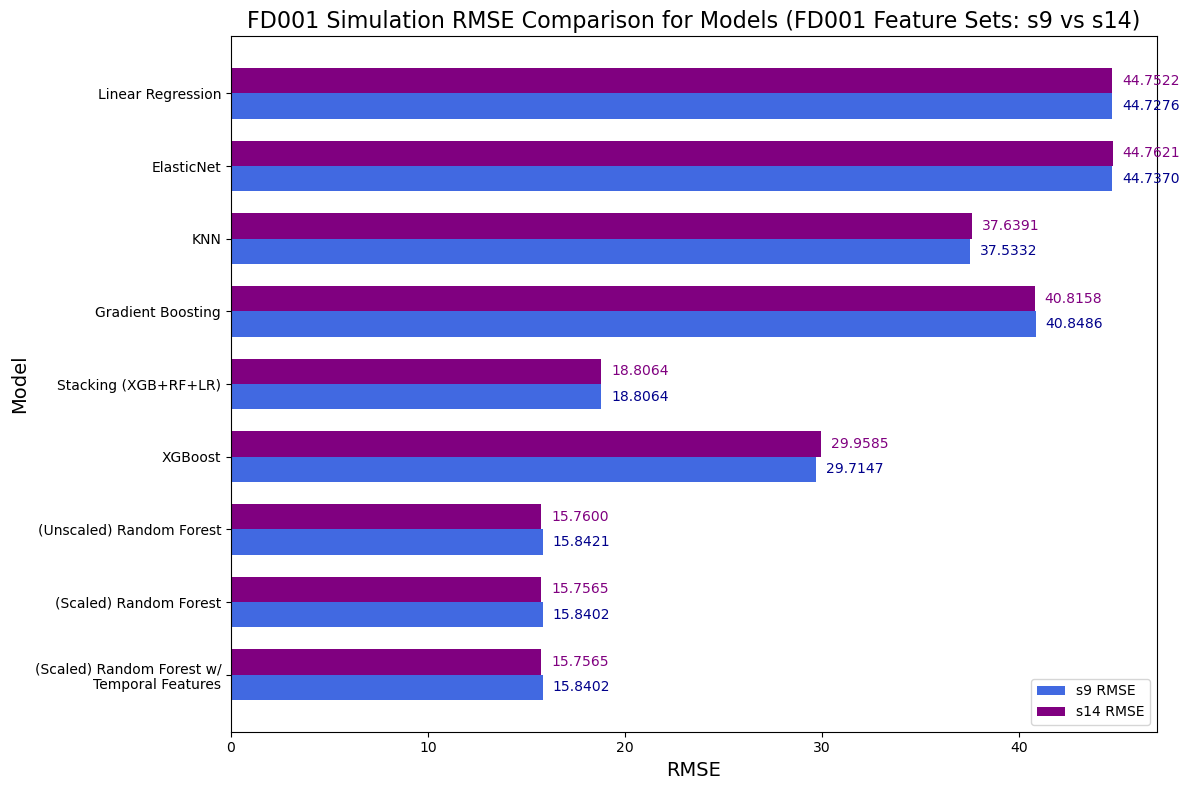

In [410]:
import textwrap

s9_rmse_model_values = {
    '(Scaled) Random Forest w/ Temporal Features': 15.8402,
    '(Scaled) Random Forest': 15.8402, 
    '(Unscaled) Random Forest': 15.8421,
    'XGBoost': 29.7147,
    'Stacking (XGB+RF+LR)': 18.8064,  
    'Gradient Boosting': 40.8486, 
    'KNN': 37.5332,  
    'ElasticNet': 44.7370,  
    'Linear Regression': 44.7276,  
}

s14_rmse_model_values = {
    '(Scaled) Random Forest w/ Temporal Features': 15.7565,
    '(Scaled) Random Forest': 15.7565, 
    '(Unscaled) Random Forest': 15.7600,
    'XGBoost': 29.9585,
    'Stacking (XGB+RF+LR)': 18.8064,  
    'Gradient Boosting': 40.8158, 
    'KNN': 37.6391,  
    'ElasticNet': 44.7621,  
    'Linear Regression': 44.7522,  
}

s9_df = pd.DataFrame(list(s9_rmse_model_values.items()), columns=['Model', 'RMSE_s9'])
s14_df = pd.DataFrame(list(s14_rmse_model_values.items()), columns=['Model', 'RMSE_s14'])

rmse_df = pd.merge(s9_df, s14_df, on='Model')

rmse_df['Model'] = [textwrap.fill(model, width=30) for model in rmse_df['Model']]

plt.figure(figsize=(12, 8))

bar_width = 0.35
index = range(len(rmse_df))

plt.barh(index, rmse_df['RMSE_s9'], bar_width, label='s9 RMSE', color='royalblue')
plt.barh([i + bar_width for i in index], rmse_df['RMSE_s14'], bar_width, label='s14 RMSE', color='purple')

plt.yticks([i + bar_width / 2 for i in index], rmse_df['Model'], rotation=0, ha='right')
plt.title("FD001 Simulation RMSE Comparison for Models (FD001 Feature Sets: s9 vs s14)", fontsize=16)
plt.xlabel('RMSE', fontsize=14)
plt.ylabel('Model', fontsize=14)

offset = 5

for i, row in rmse_df.iterrows():
    # s9 bars: text goes slightly higher, in dark blue
    plt.text(row['RMSE_s9'] + 0.5, i, f"{row['RMSE_s9']:.4f}", va='center', ha='left', color='darkblue', fontsize=10)
    # s14 bars: text stayin same position, in dark green
    plt.text(row['RMSE_s14'] + 0.5, i + bar_width, f"{row['RMSE_s14']:.4f}", va='center', ha='left', color='purple', fontsize=10)

plt.legend()
plt.tight_layout()
plt.show()

## Plot & Compare R² between Models using Sensors 2, 3, 4, 7, 9, 11, 12, 15, 21 vs. Sensors 2, 3, 4, 7, 11, 12, 14, 15, 21 
 Wang et al.’s top-ranked sensors + Sensor 9 vs. Wang et al.’s top-ranked sensors + Sensor 14

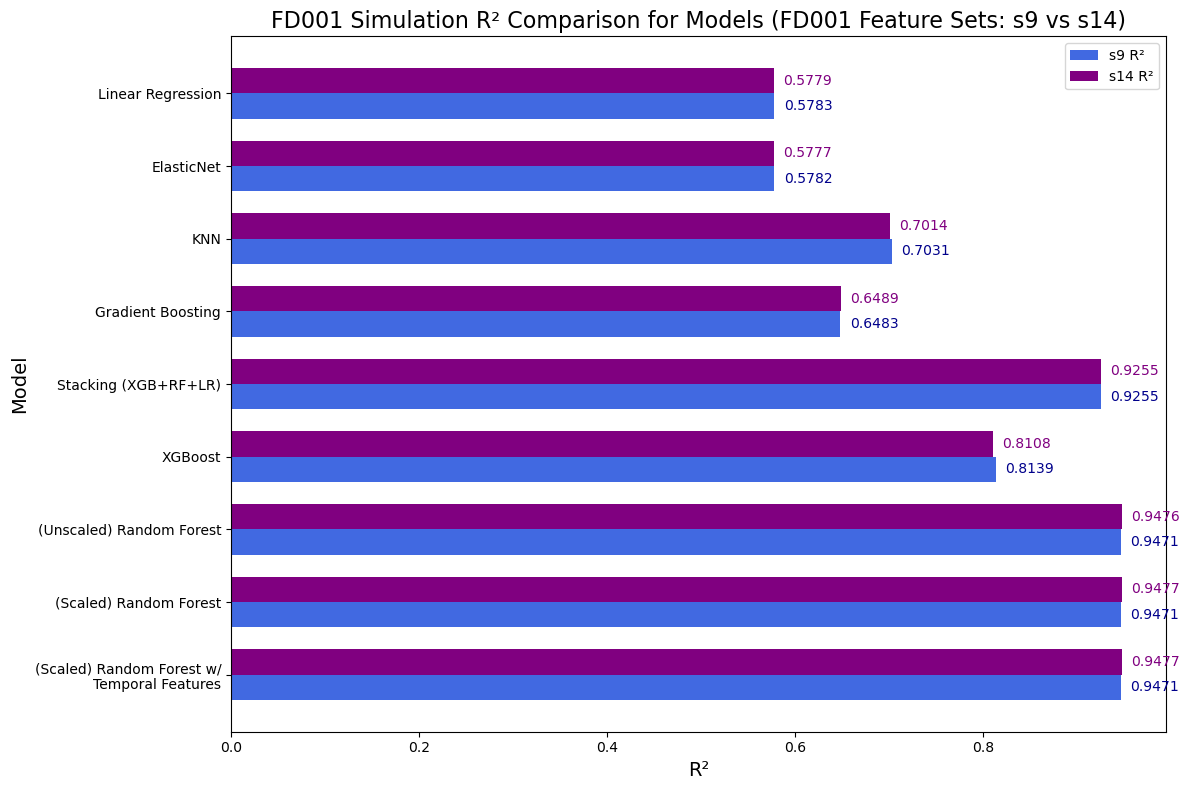

In [411]:
s9_r2_model_values = {
    '(Scaled) Random Forest w/ Temporal Features': 0.9471,
    '(Scaled) Random Forest': 0.9471, 
    '(Unscaled) Random Forest': 0.9471,
    'XGBoost': 0.8139,
    'Stacking (XGB+RF+LR)': 0.9255,  
    'Gradient Boosting': 0.6483, 
    'KNN': 0.7031,  
    'ElasticNet': 0.5782,  
    'Linear Regression': 0.5783,  
}

s14_r2_model_values = {
    '(Scaled) Random Forest w/ Temporal Features': 0.9477,
    '(Scaled) Random Forest': 0.9477, 
    '(Unscaled) Random Forest': 0.9476,
    'XGBoost': 0.8108,
    'Stacking (XGB+RF+LR)': 0.9255,  
    'Gradient Boosting': 0.6489, 
    'KNN': 0.7014,  
    'ElasticNet': 0.5777,  
    'Linear Regression': 0.5779,  
}
s9_df = pd.DataFrame(list(s9_r2_model_values.items()), columns=['Model', 'R2_s9'])
s14_df = pd.DataFrame(list(s14_r2_model_values.items()), columns=['Model', 'R2_s14'])

r2_df = pd.merge(s9_df, s14_df, on='Model')

r2_df['Model'] = [textwrap.fill(model, width=30) for model in r2_df['Model']]

plt.figure(figsize=(12, 8))

bar_width = 0.35
index = range(len(r2_df))

plt.barh(index, r2_df['R2_s9'], bar_width, label='s9 R²', color='royalblue')
plt.barh([i + bar_width for i in index], r2_df['R2_s14'], bar_width, label='s14 R²', color='purple')

plt.yticks([i + bar_width / 2 for i in index], r2_df['Model'], rotation=0, ha='right')
plt.title("FD001 Simulation R² Comparison for Models (FD001 Feature Sets: s9 vs s14)", fontsize=16)
plt.xlabel('R²', fontsize=14)
plt.ylabel('Model', fontsize=14)

for i, row in r2_df.iterrows():
    # s9 bars: text goes slightly to the right, in dark blue
    plt.text(row['R2_s9'] + 0.01, i, f"{row['R2_s9']:.4f}", va='center', ha='left', color='darkblue', fontsize=10)
    # s14 bars: text stays in the same position, in dark purple
    plt.text(row['R2_s14'] + 0.01, i + bar_width, f"{row['R2_s14']:.4f}", va='center', ha='left', color='purple', fontsize=10)

plt.legend()
plt.tight_layout()
plt.show()

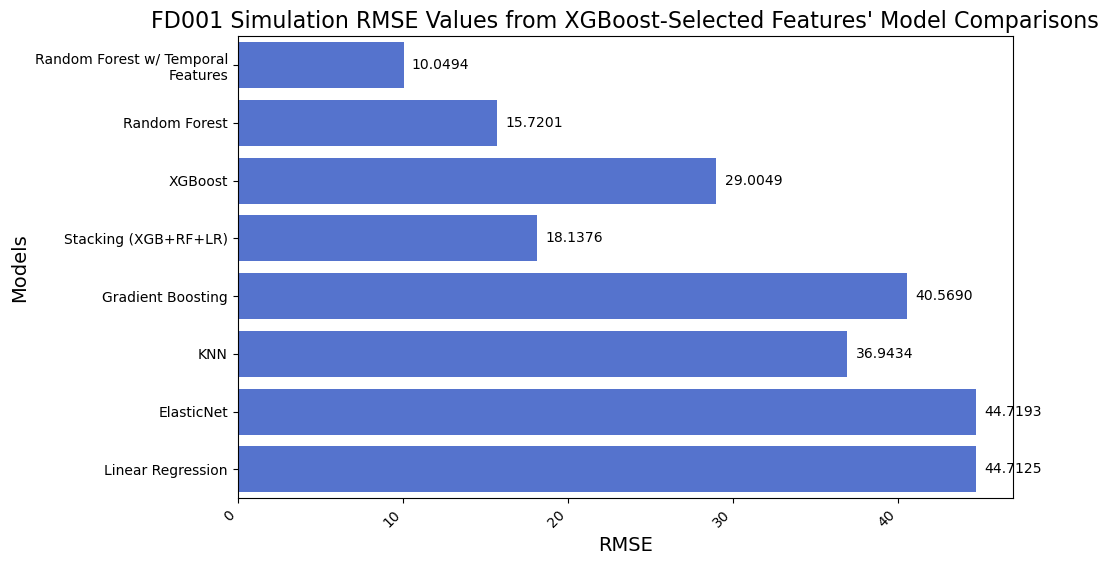

In [412]:
# XGBoost selected sensor subset: 2, 3, 4, 7, 9, 11, 12, 14, 15, 21
rmse_model_values = {
    'Random Forest w/ Temporal Features': 10.0494,
    'Random Forest': 15.7201, 
    'XGBoost': 29.0049,
    'Stacking (XGB+RF+LR)': 18.1376,  
    'Gradient Boosting': 40.5690, 
    'KNN': 36.9434,  
    'ElasticNet': 44.7193,  
    'Linear Regression': 44.7125,  
}

# wrap y-axis label text
wrapped_model_names = [textwrap.fill(model, width=30) for model in rmse_model_values.keys()]

rmse_xgb_df = pd.DataFrame(list(rmse_model_values.items()), columns=['Model', 'RMSE'])

rmse_xgb_df['Model'] = wrapped_model_names

plt.figure(figsize=(10, 6))
sns.barplot(x='RMSE', y='Model', data=rmse_xgb_df, color='royalblue')

plt.title("FD001 Simulation RMSE Values from XGBoost-Selected Features' Model Comparisons", fontsize=16)
plt.xlabel('RMSE', fontsize=14)
plt.ylabel('Models', fontsize=14)

plt.xticks(rotation=45, ha='right')

# print RMSE values to the SIDE bars
for index, row in rmse_xgb_df.iterrows():
    plt.text(row['RMSE'] + 0.5, index, f"{row['RMSE']:.4f}", va='center', color='black')

plt.show()

### Key Findings:
`Sensor_9` and `Sensor_14` are highly correlated to one another, with a correlation coefficient of 0.96. Something very interesting occurs. When`Sensor_9` and `Sensor_14` are extracted individually and combined with the rest of XGBoost's selected sensors (also same as Wang et al.'s selection of sensors, (2, 3, 4, 7, 11, 12, 15, 20, 21)), the RMSE and R² are VERY SIMILAR. However, upon comparison to the RMSE and R² results of the XGBoost Selected subset of sensors (2, 3, 4, 7, 9, 11, 12, 14, 15, 21) which includes BOTH Sensors 9 and 14, the RMSE and R2 values of those models perform much better using both 9 and 14 together in the subset. Though Sensor information is intetnially kept unknown by the Prognostics and Health Management Society, this reveals that Sensor 9 and 14 may still be able to individually capture subtle different details of the turbofan engine degradation. 

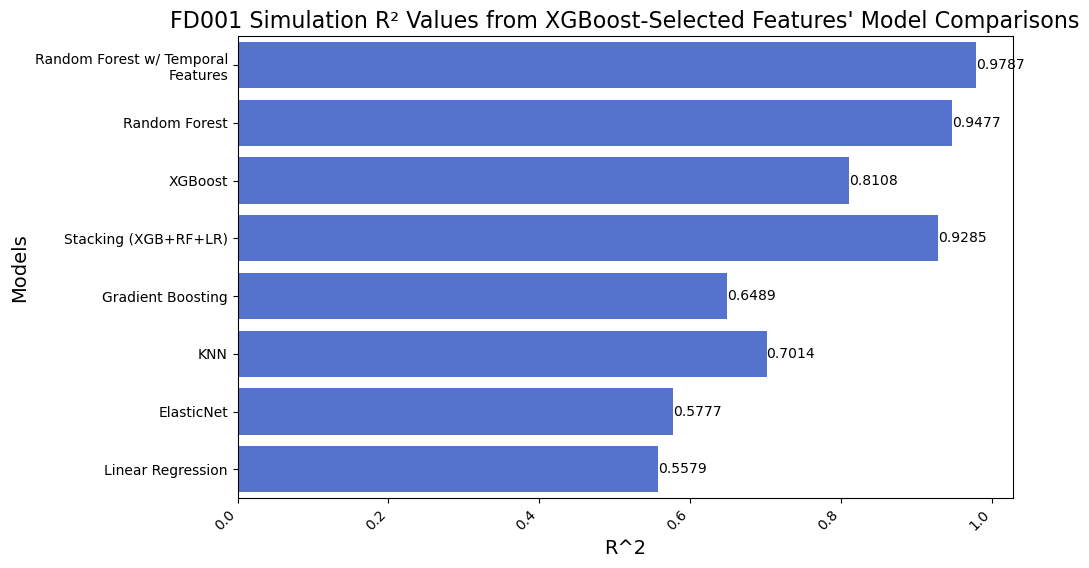

In [413]:
# visualize and compare R² Coefficient values

r2_model_values = {
    'Random Forest w/ Temporal Features': 0.9787,
    'Random Forest': 0.9477, 
    'XGBoost': 0.8108,
    'Stacking (XGB+RF+LR)': 0.9285,  
    'Gradient Boosting': 0.6489, 
    'KNN': 0.7014,  
    'ElasticNet': 0.5777,  
    'Linear Regression': 0.5579,  
}

# wrap y-axis label text
wrapped_model_names = [textwrap.fill(model, width=30) for model in r2_model_values.keys()]

r2_xgb_df = pd.DataFrame(list(r2_model_values.items()), columns=['Model', 'R^2'])

r2_xgb_df['Model'] = wrapped_model_names

plt.figure(figsize=(10, 6))
sns.barplot(x='R^2', y='Model', data=r2_xgb_df, color='royalblue')

plt.title("FD001 Simulation R² Values from XGBoost-Selected Features' Model Comparisons", fontsize=16)
plt.xlabel('R^2', fontsize=14)
plt.ylabel('Models', fontsize=14)

plt.xticks(rotation=45, ha='right')

# print RMSE values to the SIDE bars
for index, row in r2_xgb_df.iterrows():
    plt.text(row['R^2'], index, f"{row['R^2']:.4f}", va='center', color='black')

plt.show()

### Key Findings 
Since XGBoost Selected Subset of Sensors are revealed to predict RUL prediction most accurately out of all other sensor combinations, now focus ONLY on the top 3 performing models from this subset. 
#### Top 3 Performing Models in the XGBoost Selected Subset of Sensors group, aside from Adaptive sliding window RF model ((Scaled) Random Forest w/ Temporal Features)
1. (Scaled) Random Forest
2. Stacking (XGB + RF + LR)
3. XGBoost

#### Now, apply the temporal features to Stacking and XGBoost as well, so the adaptive sliding approach can be assessed with those models, too. Find RMSE and R² to compare model performance. 

In [414]:
window_size = 5  

df1['sensor_2_cumsum'] = df1.groupby("unit")['sensor_2'].cumsum()

# find rolling mean and std for all selected sensors
for sensor in key_sensors:
    df1[f"{sensor}_rolling_mean"] = df1.groupby("unit")[sensor].rolling(window=window_size).mean().reset_index(level=0, drop=True)
    df1[f"{sensor}_rolling_std"] = df1.groupby("unit")[sensor].rolling(window=window_size).std().reset_index(level=0, drop=True)

df1.fillna(0, inplace=True)

X_train = df1.drop(columns=['unit', 'time', 'RUL'])  # Drop non-predictive columns
y_train = df1['RUL']  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# XGBoost Model
xgb_model = XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

# Evaluation
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)
print(f"XGBoost with Adaptive Sliding Window - RMSE: {rmse_xgb:.4f}")
print(f"XGBoost with Adaptive Sliding Window - R²: {r2_xgb:.4f}")

XGBoost with Adaptive Sliding Window - RMSE: 43.4001
XGBoost with Adaptive Sliding Window - R²: 0.5877


In [415]:
estimators = [
    ('xgb', XGBRegressor(n_estimators=100, random_state=42)),
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42))
]

model_stack = StackingRegressor(estimators=estimators, final_estimator=LinearRegression())
model_stack.fit(X_train, y_train)
y_pred_stack = model_stack.predict(X_test)

rmse_stack = np.sqrt(mean_squared_error(y_test, y_pred_stack))
r2_stack = r2_score(y_test, y_pred_stack)
print(f"Stacking Model with Adaptive Sliding Window RMSE: {rmse_stack:.4f}")
print(f"Stacking Model with Adaptive Sliding Window R²: {r2_stack:.4f}")

Stacking Model with Adaptive Sliding Window RMSE: 41.3974
Stacking Model with Adaptive Sliding Window R²: 0.6249


### Top 3 Model Comparison using Adaptive Sliding Window Strategy (Comparing RMSE and R² Values)
Now compare only the RMSE and R² Values of the Top 3 Adapted Models

/var/folders/6k/rhyhn5ps2jj8zjfvkgv2h9680000gp/T/ipykernel_76352/610667604.py:21: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='RMSE', y='Model', data=rmse_df, color='royalblue', label="RMSE", ci=None)
/var/folders/6k/rhyhn5ps2jj8zjfvkgv2h9680000gp/T/ipykernel_76352/610667604.py:22: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='R²', y='Model', data=r2_df, color='pink', label="R²", ci=None)


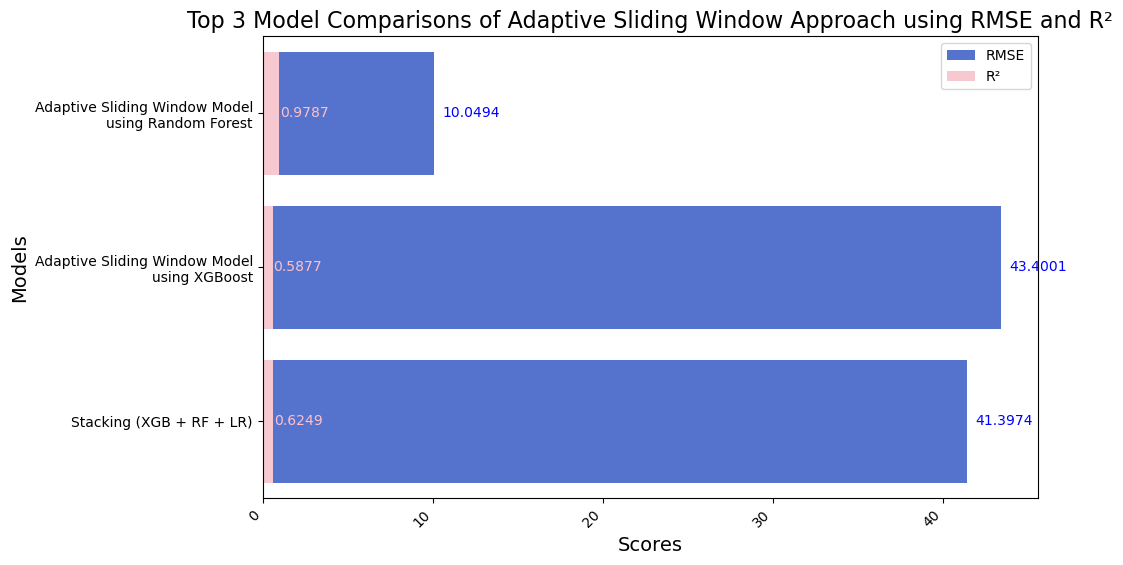

In [416]:
rmse_top3_values = {
    'Adaptive Sliding Window Model using Random Forest': 10.0494,
    'Adaptive Sliding Window Model using XGBoost': 43.4001,   
    'Stacking (XGB + RF + LR)': 41.3974,
}
r2_top3_values = {
    'Adaptive Sliding Window Model using Random Forest': 0.9787,
    'Adaptive Sliding Window Model using XGBoost': 0.5877,   
    'Stacking (XGB + RF + LR)': 0.6249,
}

wrapped_models = [textwrap.fill(model, width=30) for model in rmse_top3_values.keys()]

rmse_df = pd.DataFrame(list(rmse_top3_values.items()), columns=['Model', 'RMSE'])
r2_df = pd.DataFrame(list(r2_top3_values.items()), columns=['Model', 'R²'])

rmse_df['Model'] = wrapped_models
r2_df['Model'] = wrapped_models

plt.figure(figsize=(10, 6))
sns.barplot(x='RMSE', y='Model', data=rmse_df, color='royalblue', label="RMSE", ci=None)
sns.barplot(x='R²', y='Model', data=r2_df, color='pink', label="R²", ci=None)

# RMSE value labels in blue
for index, row in rmse_df.iterrows():
    plt.text(row['RMSE'] + 0.5, index, f"{row['RMSE']:.4f}", va='center', color='blue')

# R2 value labels in purple
for index, row in r2_df.iterrows():
    plt.text(row['R²'] + 0.05, index, f"{row['R²']:.4f}", va='center', color='pink')

plt.title("Top 3 Model Comparisons of Adaptive Sliding Window Approach using RMSE and R²", fontsize=16)
plt.xlabel('Scores', fontsize=14)
plt.ylabel('Models', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.show()

#### Key Findings
Figure is comparing the RMSE and R² values of the top three performing models from the XGB-selected subset of features, which was the best selection out of the four different combinations of sensors. 

### Random Forest: Adaptive Sliding Window vs. Fixed Window Models RMSE Comparison
Just for fun: Now compare only the RF models-- visualize the Random Forest Adaptive Sliding Window vs. Fixed Window Models. Run code below to see how it compares!

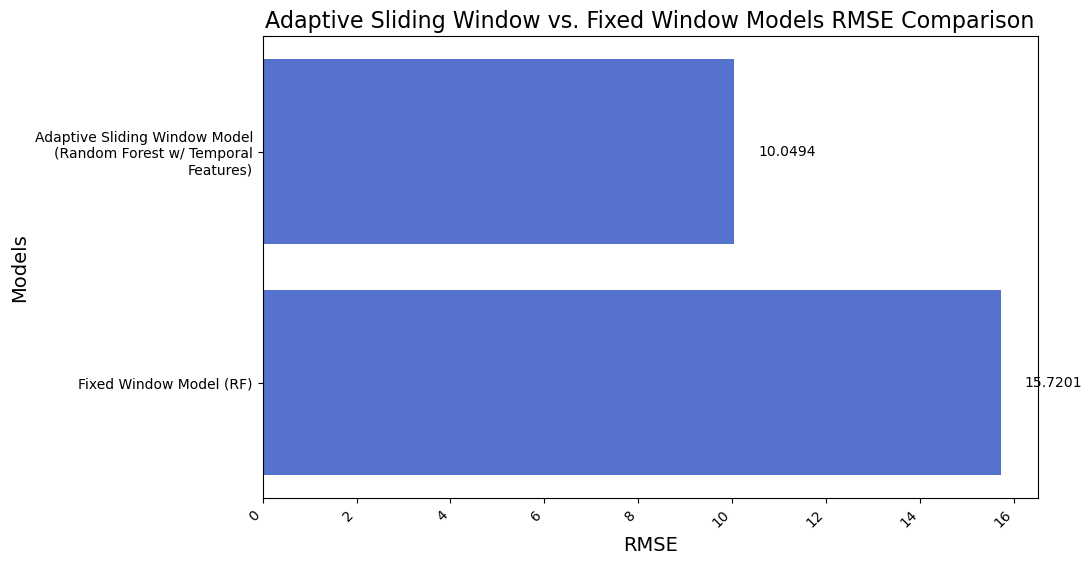

In [417]:
rmse_rf_values = {
    'Adaptive Sliding Window Model (Random Forest w/ Temporal Features)': 10.0494,
    'Fixed Window Model (RF)': 15.7201,   
}

# wrap text
wrapped_models = [textwrap.fill(model, width=30) for model in rmse_rf_values.keys()]

rmse_rf_df = pd.DataFrame(list(rmse_rf_values.items()), columns=['Model', 'RMSE'])

rmse_rf_df['Model'] = wrapped_models

plt.figure(figsize=(10, 6))
sns.barplot(x='RMSE', y='Model', data=rmse_rf_df, color='royalblue')

plt.title("Adaptive Sliding Window vs. Fixed Window Models RMSE Comparison", fontsize=16)
plt.xlabel('RMSE', fontsize=14)
plt.ylabel('Models', fontsize=14)
plt.xticks(rotation=45, ha='right')

for index, row in rmse_rf_df.iterrows():
    plt.text(row['RMSE'] + 0.5, index, f"{row['RMSE']:.4f}", va='center', color='black')
plt.show()

### Implementation of Milestone 2 Feedback on the Addition of temporal features into Adaptive Sliding Window Approach

BIG improvement; RMSE dropped from 15.72 (RF w/o temporal features | FIXED WINDOW) to 10.05 (w/ temporal features | ADAPTIVE)
- proves that temporal dependencies significantly improves RUL prediction --> TA gave very beneficia feedback in Milestone 2 submission.
- all models are trained under the same preprocessing conditions -->  RMSE comparisons to be fair and reliable

#### To ensure TA's comments from Milestone 2 are addressed:
- Rolling mean and standard deviation -->  capture local trends and variability
- Cumulative sum --> tracks degradation over time

### Implementation of Milestone 3 Feedback from TA: "The adaptive sliding window approach was implemented with Random Forest, but why not other models?"
This is very beneficial feedback, as there could definitely be drastic improvements using other models with the temporal features. With this newest and final Milestone submission, the top 3 performing models that produced the smallest RMSE were chosen to incorporate the temporal features as well. The top 3 models are as listed: Adaptive Sliding Window Model using Random Forest, Adaptive Sliding Window Model using XGBoost, and Stacking (XGBoost + Random Forest + Linear Regression). Only these three models are chosen to implement the adaptive sliding window approach, as their performance in RUL prediction was signficiantly better than the rest of the other models. As a result, the Adaptive Sliding Window Model using Random Forest has an RMSE of 10.0494 and an R² value of 0.9787, the Adaptive Sliding Window Model using XGBoost has an RMSE of 43.4001 and an R² value of 0.5877, and finally the Stacking model has an RMSE of 41.3974 and an R² value 0.6249. In comparing all three top performing models, the Adaptive Sliding Window Model using Random Forest outperforms the other two. 

In the context of RUL prediction accuracy, the random forest adaptive sliding window model’s predictions are, on average, about 10 cycles off from the true remaining life — which is remarkably low. In addition, its R² value of 0.9787 indicates that 97.87% of the variation in the engine’s remaining life is captured by the model. The closer the value is to 1, the better the model fits the simulation data. This shows that the model is extremely effective at understanding the turbofan engine degradation patterns, leaving very little unexplained error. With the combination of these two evaluation metrics, the adaptive random forest model is not only accurate but also reliable at tracking the engine's health over time.